## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [3]:
df = pd.read_csv("../../Datasets/Datos_antes_pandemia/data_antes_vol_in.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df = df.rename(columns = {'Futuros': 'Vol. Futuros'})
df

Fecha  Vol. Futuros        VIX  EMV-ID     EPU
0    2010-01-01      0.000000  22.543626    2.01  174.55
1    2010-01-02      4.256365  22.171185    0.00  119.52
2    2010-01-03      0.794545  21.143152    1.15  216.95
3    2010-01-04      0.787899  20.040000    1.22  150.35
4    2010-01-05      0.601027  19.350000    0.95  151.16
...         ...           ...        ...     ...     ...
3648 2019-12-27      4.003614  13.430000    0.00  127.92
3649 2019-12-28      2.090121  14.351756    0.00  123.10
3650 2019-12-29      0.539108  14.946538    4.26  245.14
3651 2019-12-30      1.815513  14.820000    0.97  101.31
3652 2019-12-31      1.871355  13.780000    1.54  105.75

[3653 rows x 5 columns]

---

## Desarrollo del modelo LSTM

In [5]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [6]:
df_stats=df

In [7]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos



In [8]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

In [9]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [10]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [11]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [12]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    lag=lag
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    return [{"Fecha":df_stats.Fecha[lag:eight_percent],"typeLSTM":["train"]*len(trainPredict.flatten()),"LSTM" :trainPredict.flatten()}
        ,{"Fecha":df_stats.Fecha[eight_percent+lag:],"typeLSTM":["test"]*len(testPredict.flatten()),"LSTM":testPredict.flatten()}]
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

## Resultados

(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 3s 9ms/step - loss: 1.1592 - mae: 0.7669 - val_loss: 0.7908 - val_mae: 0.6869
Epoch 2/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1420 - mae: 0.7639 - val_loss: 0.7950 - val_mae: 0.6948
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1333 - mae: 0.7656 - val_loss: 0.7972 - val_mae: 0.6983
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1271 - mae: 0.7649 - val_loss: 0.7979 - val_mae: 0.7000
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1226 - mae: 0.7630 - val_loss: 0.7994 - val_mae: 0.7017
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1188 - mae: 0.7645 - val_loss: 0.7994 - val_mae: 0.7022
Epoch 7/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1154 - mae: 0.7635 - val_loss: 0.7988 - val_mae: 0.7015
Epoch 8/100
128/128 [==

Epoch 62/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0663 - mae: 0.7488 - val_loss: 0.7974 - val_mae: 0.7086
Epoch 63/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0653 - mae: 0.7503 - val_loss: 0.7955 - val_mae: 0.7068
Epoch 64/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0652 - mae: 0.7496 - val_loss: 0.7916 - val_mae: 0.7031
Epoch 65/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0639 - mae: 0.7475 - val_loss: 0.7959 - val_mae: 0.7072
Epoch 66/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0634 - mae: 0.7488 - val_loss: 0.7959 - val_mae: 0.7074
Epoch 67/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0628 - mae: 0.7500 - val_loss: 0.7956 - val_mae: 0.7069
Epoch 68/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0617 - mae: 0.7480 - val_loss: 0.7974 - val_mae: 0.7084
Epoch 69/100
128/128 [==============================] - 1s 5ms

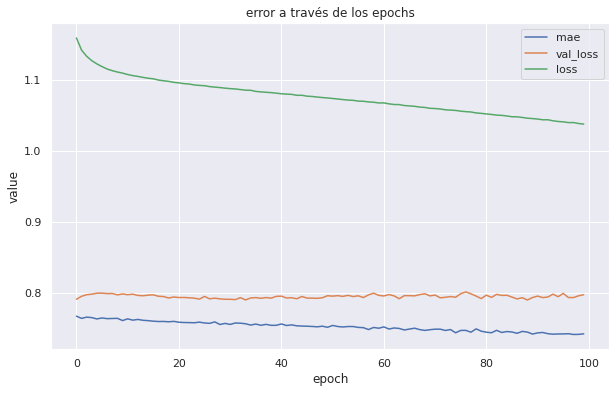

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.2805440352943036
MAE is : 0.836488133053581
RMSE is : 1.131611256259986
MAPE is : 41.79058008866381
Evaluation metric results:
MSE is : 1.010709149450571
MAE is : 0.7821961263427553
RMSE is : 1.0053403152418443
MAPE is : 43.70362947143768
(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 3s 9ms/step - loss: 1.1708 - mae: 0.7685 - val_loss: 0.8091 - val_mae: 0.7033
Epoch 2/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1391 - mae: 0.7656 - val_loss: 0.8110 - val_mae: 0.7088
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1276 - mae: 0.7687 - val_loss: 0.8090 - val_mae: 0.7083
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1209 - mae: 0.7659 - val_loss: 0.8042 - val_mae: 0.7047
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1166 - mae: 0.7

128/128 [==============================] - 1s 5ms/step - loss: 1.0568 - mae: 0.7484 - val_loss: 0.8014 - val_mae: 0.7112
Epoch 60/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0548 - mae: 0.7461 - val_loss: 0.7980 - val_mae: 0.7088
Epoch 61/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0554 - mae: 0.7482 - val_loss: 0.7962 - val_mae: 0.7067
Epoch 62/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0530 - mae: 0.7441 - val_loss: 0.8015 - val_mae: 0.7112
Epoch 63/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0513 - mae: 0.7458 - val_loss: 0.7987 - val_mae: 0.7081
Epoch 64/100
128/128 [==============================] - 1s 4ms/step - loss: 1.0518 - mae: 0.7449 - val_loss: 0.7924 - val_mae: 0.7033
Epoch 65/100
128/128 [==============================] - 1s 5ms/step - loss: 1.0497 - mae: 0.7429 - val_loss: 0.8003 - val_mae: 0.7101
Epoch 66/100
128/128 [==============================] - 1s 5ms/step - loss:

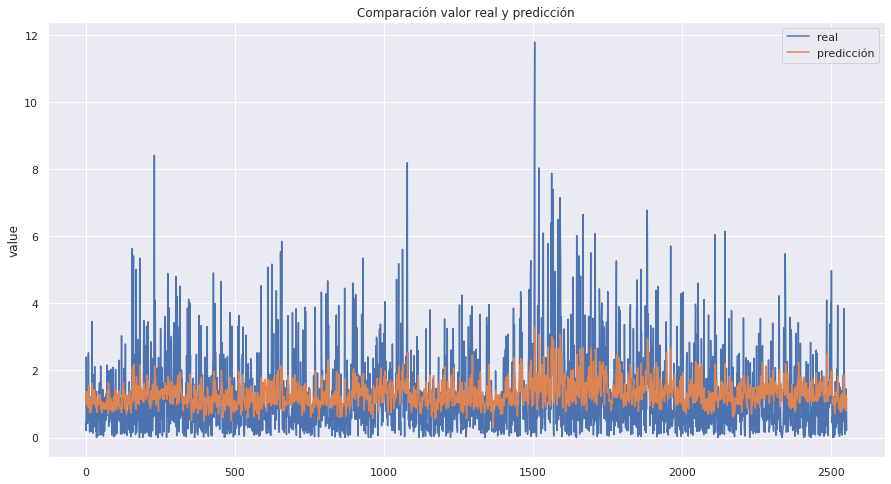

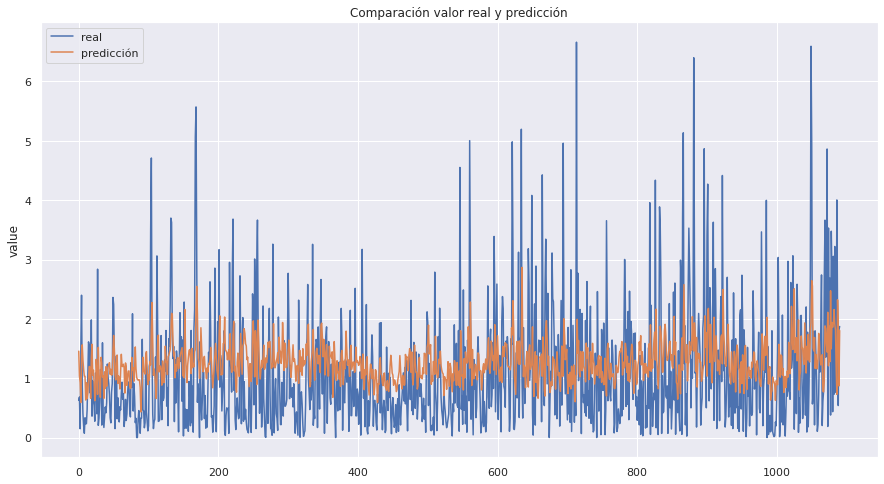

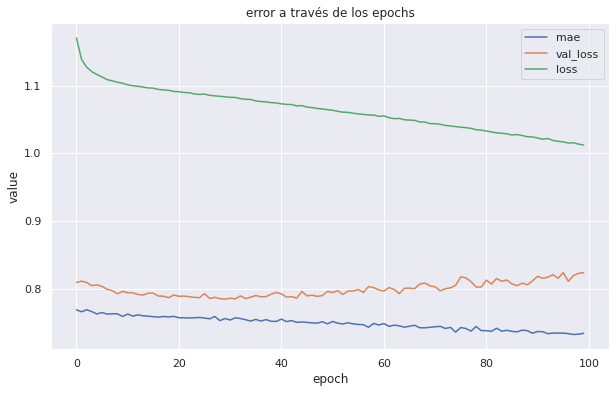

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.258189824094322
MAE is : 0.8290139036156671
RMSE is : 1.1216906097914532
MAPE is : 41.48092223248801
Evaluation metric results:
MSE is : 1.0170763180926312
MAE is : 0.7846507578557095
RMSE is : 1.0085020169006262
MAPE is : 43.53860912645511
(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 3s 9ms/step - loss: 1.1316 - mae: 0.7650 - val_loss: 0.8020 - val_mae: 0.7014
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1163 - mae: 0.7647 - val_loss: 0.7989 - val_mae: 0.7013
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1113 - mae: 0.7669 - val_loss: 0.7956 - val_mae: 0.6996
Epoch 4/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1085 - mae: 0.7637 - val_loss: 0.7911 - val_mae: 0.6966
Epoch 5/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1068 - mae: 0

Epoch 59/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0286 - mae: 0.7383 - val_loss: 0.8204 - val_mae: 0.7171
Epoch 60/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0254 - mae: 0.7360 - val_loss: 0.8289 - val_mae: 0.7225
Epoch 61/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0253 - mae: 0.7378 - val_loss: 0.8308 - val_mae: 0.7218
Epoch 62/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0222 - mae: 0.7325 - val_loss: 0.8322 - val_mae: 0.7234
Epoch 63/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0188 - mae: 0.7346 - val_loss: 0.8304 - val_mae: 0.7204
Epoch 64/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0188 - mae: 0.7329 - val_loss: 0.8179 - val_mae: 0.7103
Epoch 65/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0173 - mae: 0.7310 - val_loss: 0.8346 - val_mae: 0.7249
Epoch 66/100
128/128 [==============================] - 1s 6ms

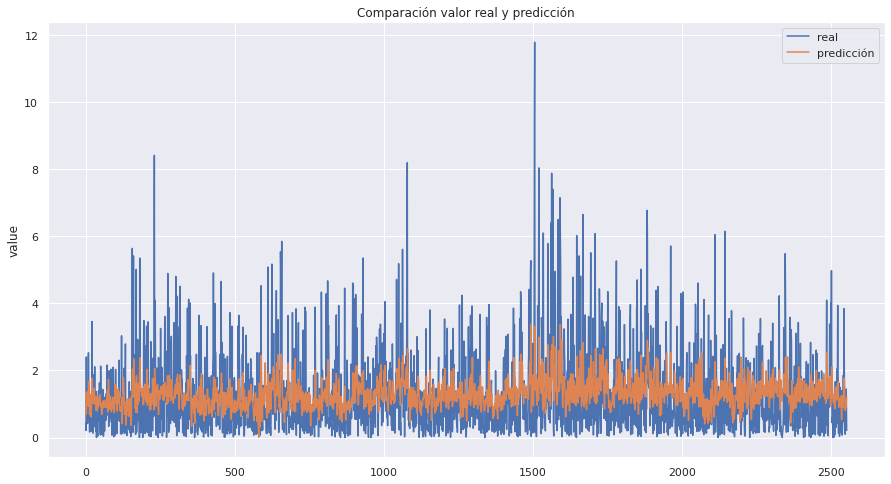

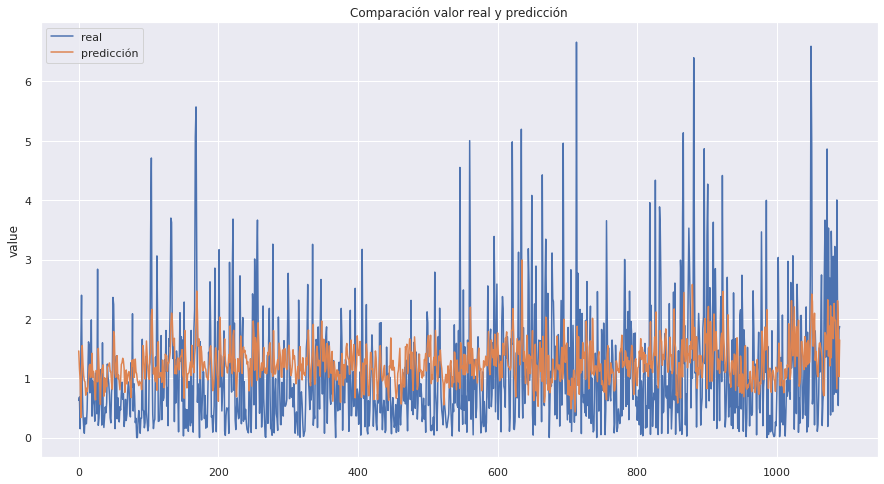

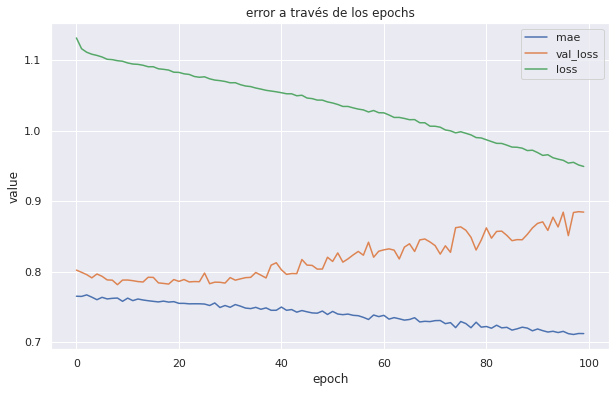

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.202724007254447
MAE is : 0.8106797155031508
RMSE is : 1.0966877437331224
MAPE is : 40.463312977228796
Evaluation metric results:
MSE is : 1.0643179387920623
MAE is : 0.8031498359064948
RMSE is : 1.0316578593662058
MAPE is : 44.385365073485524
(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 12ms/step - loss: 1.1338 - mae: 0.7667 - val_loss: 0.7986 - val_mae: 0.7014
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1191 - mae: 0.7663 - val_loss: 0.7892 - val_mae: 0.6951
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1124 - mae: 0.7672 - val_loss: 0.7868 - val_mae: 0.6940
Epoch 4/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1086 - mae: 0.7635 - val_loss: 0.7825 - val_mae: 0.6912
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1074 - mae

Epoch 59/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0062 - mae: 0.7303 - val_loss: 0.8353 - val_mae: 0.7186
Epoch 60/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0029 - mae: 0.7265 - val_loss: 0.8544 - val_mae: 0.7316
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9996 - mae: 0.7280 - val_loss: 0.8830 - val_mae: 0.7446
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9988 - mae: 0.7225 - val_loss: 0.8651 - val_mae: 0.7369
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9920 - mae: 0.7239 - val_loss: 0.8459 - val_mae: 0.7212
Epoch 64/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9915 - mae: 0.7217 - val_loss: 0.8387 - val_mae: 0.7121
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9921 - mae: 0.7207 - val_loss: 0.8725 - val_mae: 0.7423
Epoch 66/100
128/128 [==============================] - 1s 9ms

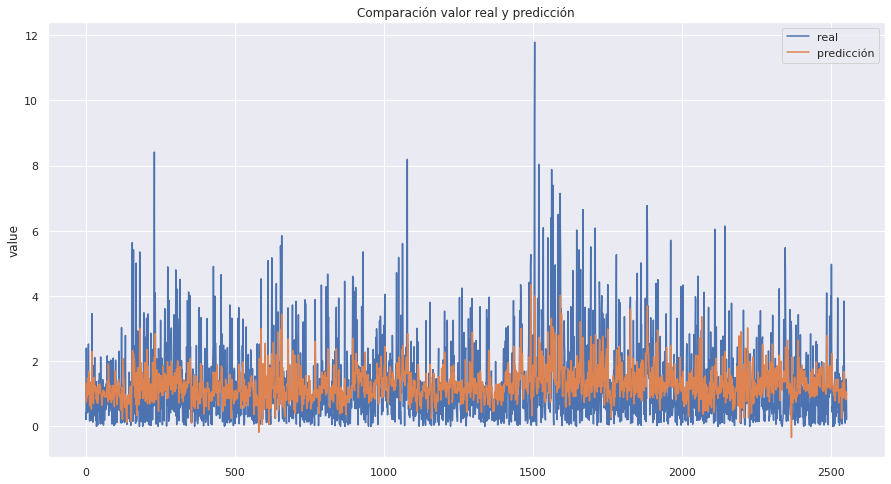

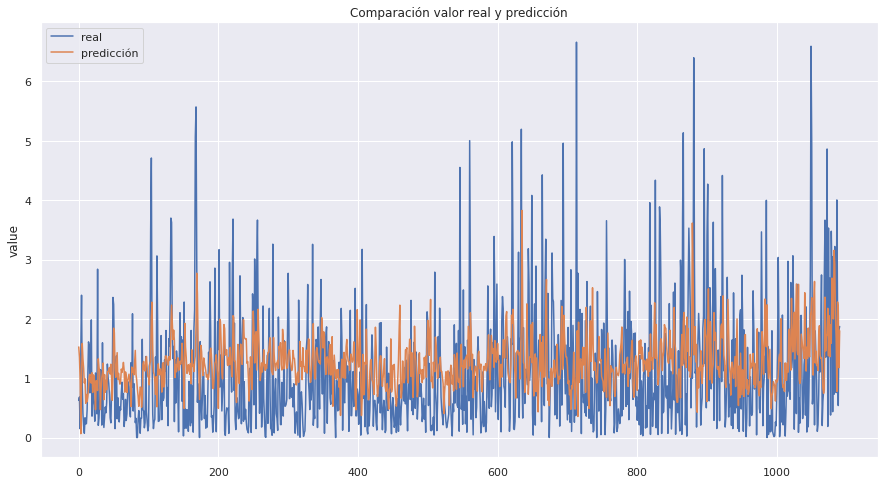

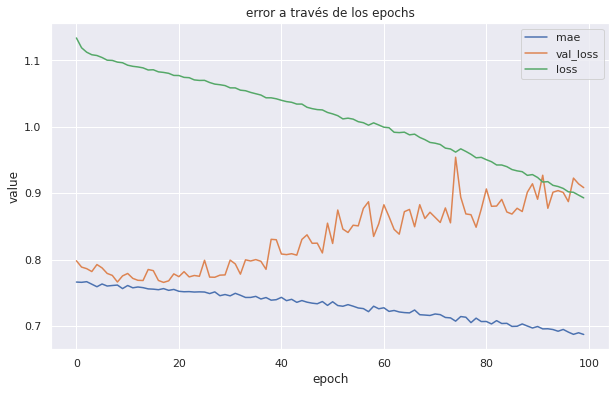

35/35 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.1454796934038287
MAE is : 0.7851667808120368
RMSE is : 1.0702708504877767
MAPE is : 39.00240678172174
Evaluation metric results:
MSE is : 1.0660739469763083
MAE is : 0.789681353734215
RMSE is : 1.032508569928748
MAPE is : 42.700033409612956
(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 5s 21ms/step - loss: 1.1460 - mae: 0.7726 - val_loss: 0.8059 - val_mae: 0.7095
Epoch 2/100
128/128 [==============================] - 2s 15ms/step - loss: 1.1228 - mae: 0.7678 - val_loss: 0.7845 - val_mae: 0.6925
Epoch 3/100
128/128 [==============================] - 2s 15ms/step - loss: 1.1124 - mae: 0.7668 - val_loss: 0.7811 - val_mae: 0.6926
Epoch 4/100
128/128 [==============================] - 2s 15ms/step - loss: 1.1067 - mae: 0.7630 - val_loss: 0.7799 - val_mae: 0.6925
Epoch 5/100
128/128 [==============================] - 2s 14ms/step - loss: 1.1064 - m

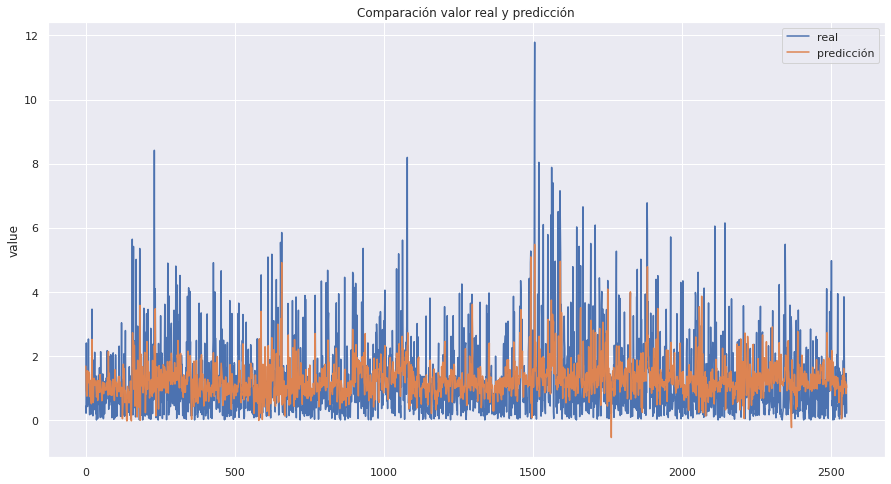

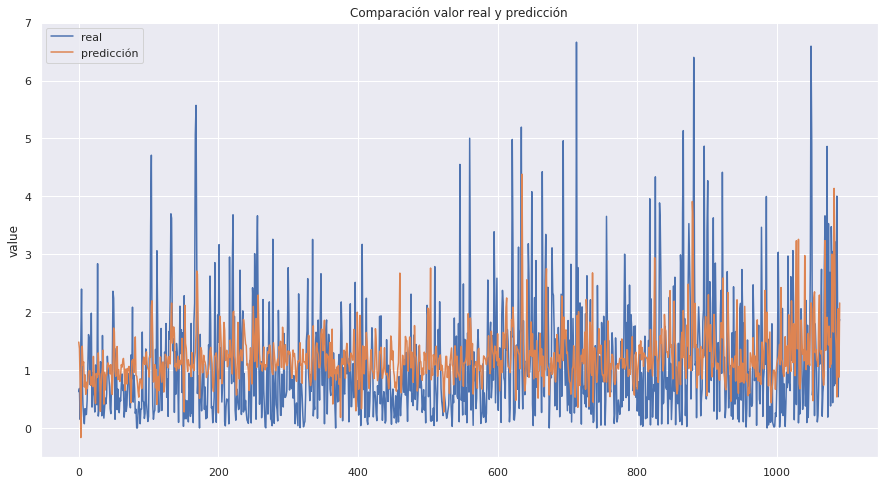

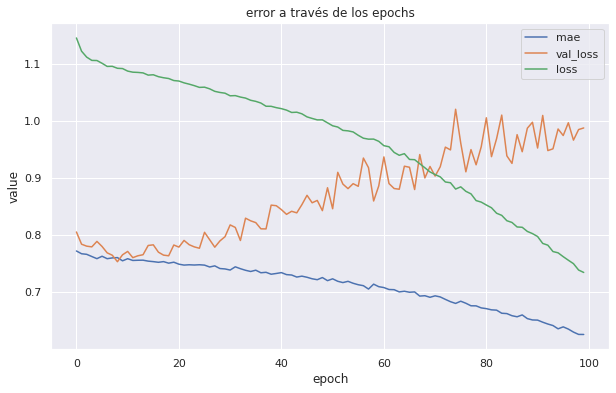

35/35 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 0.9852248711667669
MAE is : 0.7258667806960822
RMSE is : 0.9925849440560576
MAPE is : 36.08579220321949
Evaluation metric results:
MSE is : 1.2095961524593861
MAE is : 0.8310283008524549
RMSE is : 1.0998164176167704
MAPE is : 44.74225466851933
(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 6s 29ms/step - loss: 1.1392 - mae: 0.7708 - val_loss: 0.7961 - val_mae: 0.7052
Epoch 2/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1164 - mae: 0.7654 - val_loss: 0.7686 - val_mae: 0.6845
Epoch 3/100
128/128 [==============================] - 3s 25ms/step - loss: 1.1055 - mae: 0.7641 - val_loss: 0.7661 - val_mae: 0.6841
Epoch 4/100
128/128 [==============================] - 3s 24ms/step - loss: 1.0987 - mae: 0.7601 - val_loss: 0.7672 - val_mae: 0.6858
Epoch 5/100
128/128 [==============================] - 3s 25ms/step - loss: 1.1004 - 

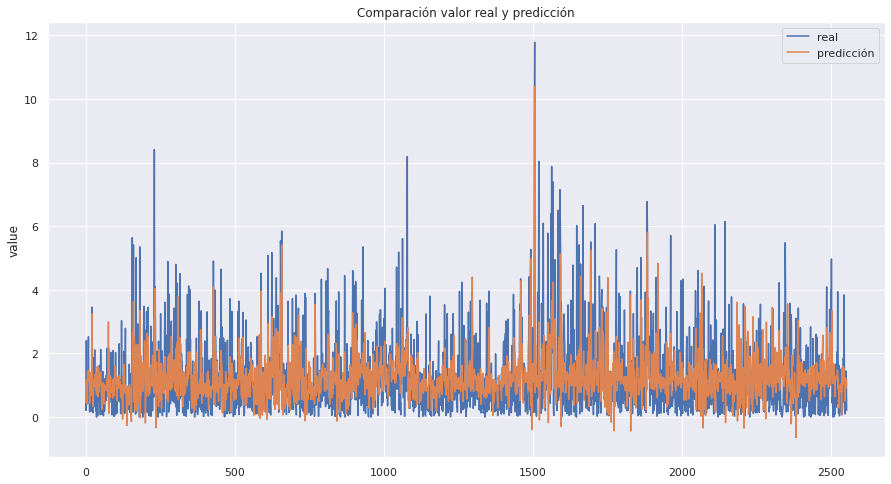

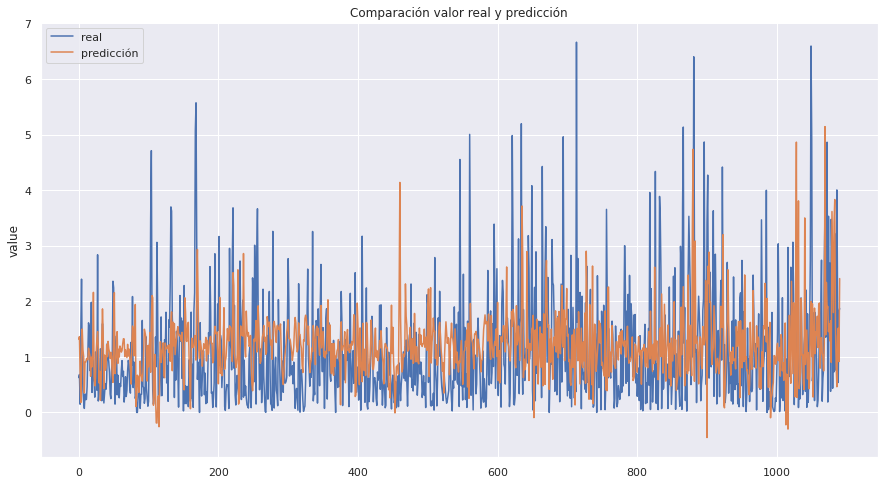

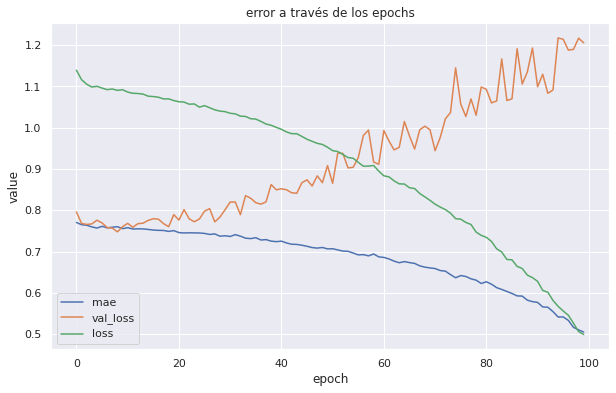

35/35 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 0.7776858417658511
MAE is : 0.6175993148555503
RMSE is : 0.8818649793283839
MAPE is : 31.378881918717518
Evaluation metric results:
MSE is : 1.4826029782725785
MAE is : 0.9241652843461698
RMSE is : 1.2176218535623358
MAPE is : 50.259432832552264
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 12ms/step - loss: 1.1532 - mae: 0.7603 - val_loss: 0.8140 - val_mae: 0.7074
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1377 - mae: 0.7621 - val_loss: 0.8146 - val_mae: 0.7119
Epoch 3/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1305 - mae: 0.7638 - val_loss: 0.8122 - val_mae: 0.7105
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1251 - mae: 0.7626 - val_loss: 0.8128 - val_mae: 0.7127
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1211 - ma

Epoch 59/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0512 - mae: 0.7390 - val_loss: 0.8185 - val_mae: 0.7328
Epoch 60/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0511 - mae: 0.7404 - val_loss: 0.8155 - val_mae: 0.7304
Epoch 61/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0507 - mae: 0.7410 - val_loss: 0.8212 - val_mae: 0.7350
Epoch 62/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0484 - mae: 0.7425 - val_loss: 0.8159 - val_mae: 0.7306
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0475 - mae: 0.7392 - val_loss: 0.8192 - val_mae: 0.7335
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0467 - mae: 0.7423 - val_loss: 0.8118 - val_mae: 0.7274
Epoch 65/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0461 - mae: 0.7396 - val_loss: 0.8099 - val_mae: 0.7262
Epoch 66/100
128/128 [==============================] - 1s 7ms

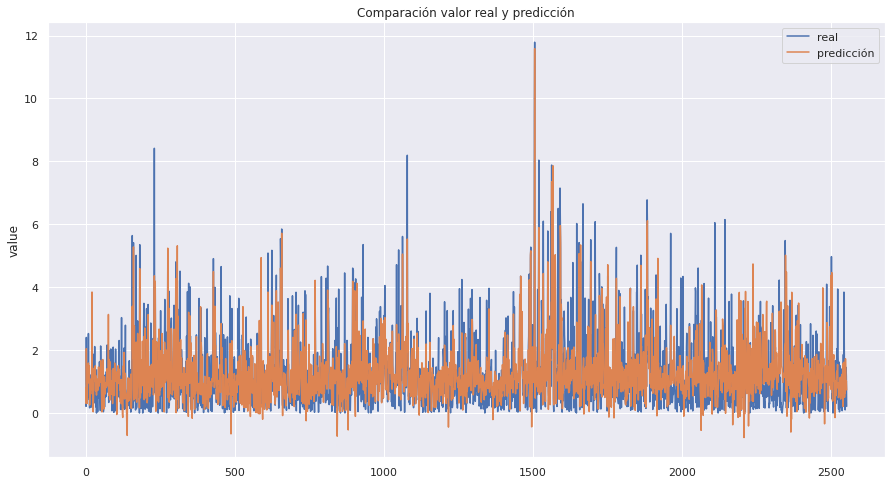

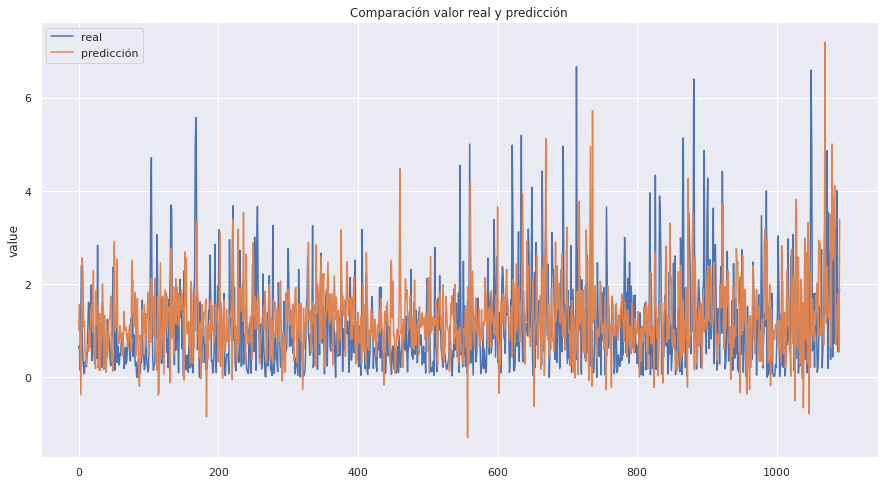

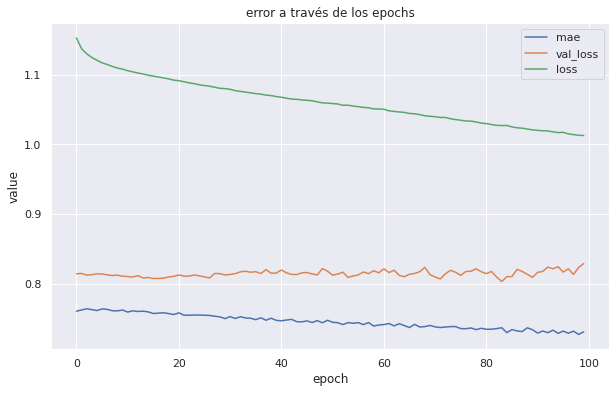

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.2612129774495597
MAE is : 0.8316797431536961
RMSE is : 1.1230373891592211
MAPE is : 41.93685199101975
Evaluation metric results:
MSE is : 0.9864859042698718
MAE is : 0.769800194692366
RMSE is : 0.9932199677160503
MAPE is : 42.41580737310939
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 13ms/step - loss: 1.1513 - mae: 0.7610 - val_loss: 0.8006 - val_mae: 0.6999
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1284 - mae: 0.7656 - val_loss: 0.8130 - val_mae: 0.7151
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1215 - mae: 0.7666 - val_loss: 0.8068 - val_mae: 0.7070
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1167 - mae: 0.7641 - val_loss: 0.8122 - val_mae: 0.7140
Epoch 5/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1128 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 10ms/step - loss: 1.0429 - mae: 0.7357 - val_loss: 0.8184 - val_mae: 0.7323
Epoch 60/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0428 - mae: 0.7379 - val_loss: 0.8112 - val_mae: 0.7262
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0444 - mae: 0.7391 - val_loss: 0.8244 - val_mae: 0.7374
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0403 - mae: 0.7407 - val_loss: 0.8113 - val_mae: 0.7261
Epoch 63/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0391 - mae: 0.7356 - val_loss: 0.8223 - val_mae: 0.7355
Epoch 64/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0374 - mae: 0.7406 - val_loss: 0.8000 - val_mae: 0.7150
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 1.0382 - mae: 0.7352 - val_loss: 0.7989 - val_mae: 0.7146
Epoch 66/100
128/128 [==============================] - 1s 9m

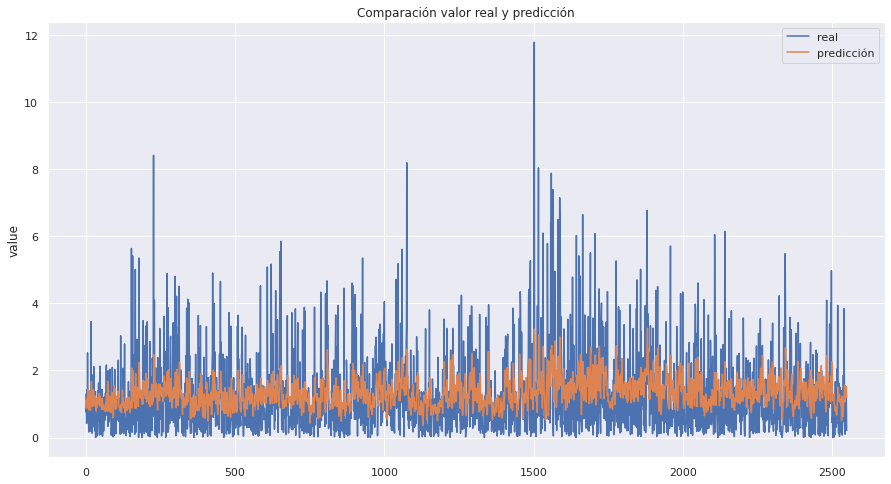

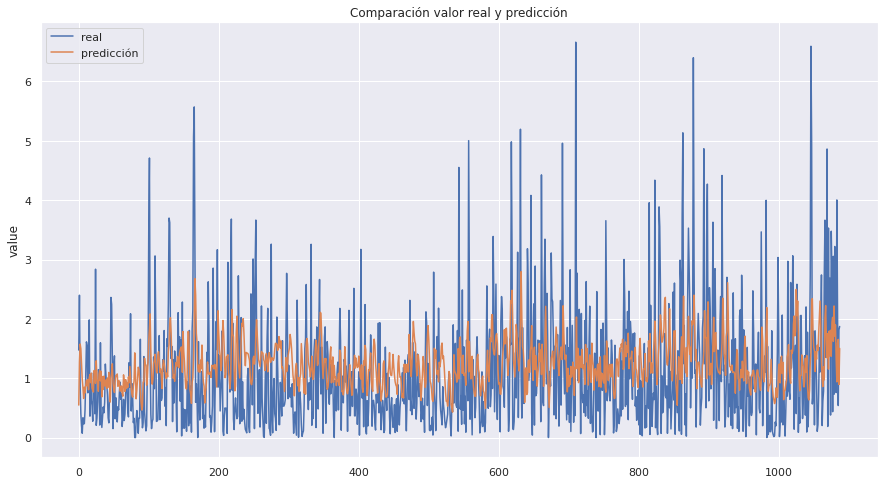

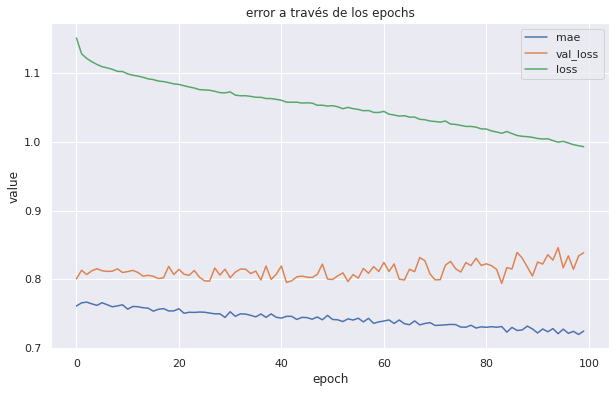

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2406855940274064
MAE is : 0.8213460157357612
RMSE is : 1.1138606708324907
MAPE is : 41.095110877372875
Evaluation metric results:
MSE is : 0.9819207657261176
MAE is : 0.7628794882863863
RMSE is : 0.9909191519625189
MAPE is : 41.820378489807354
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 5s 16ms/step - loss: 1.1688 - mae: 0.7696 - val_loss: 0.8080 - val_mae: 0.7034
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1351 - mae: 0.7689 - val_loss: 0.8200 - val_mae: 0.7182
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1265 - mae: 0.7690 - val_loss: 0.8043 - val_mae: 0.7028
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1193 - mae: 0.7647 - val_loss: 0.8110 - val_mae: 0.7138
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1122 

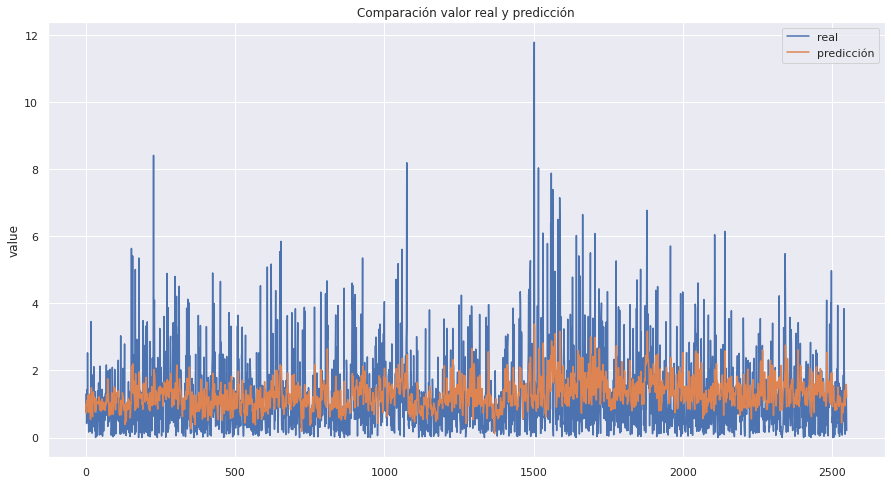

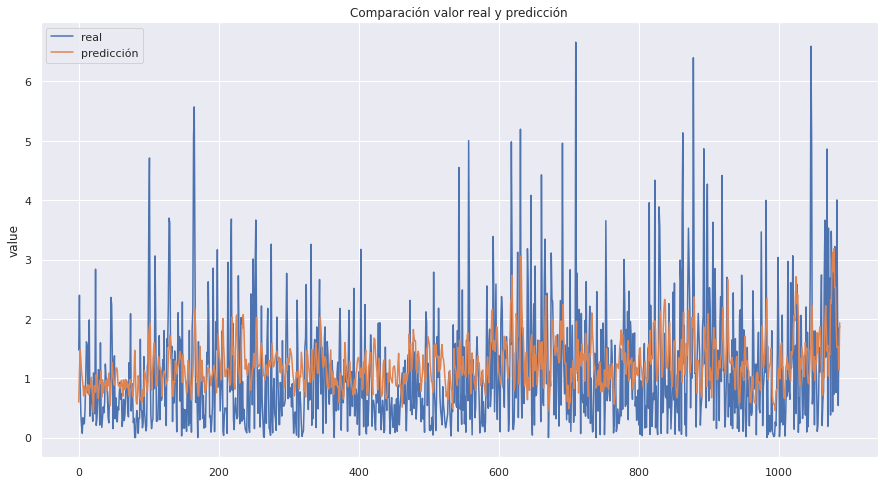

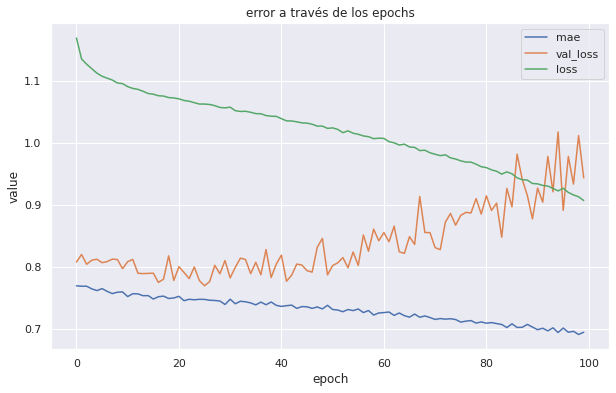

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.1729454873311578
MAE is : 0.7940792712742923
RMSE is : 1.083026078786267
MAPE is : 39.16197631024179
Evaluation metric results:
MSE is : 1.0425885534234551
MAE is : 0.7660551620530517
RMSE is : 1.0210722567102952
MAPE is : 40.04714082040504
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 5s 19ms/step - loss: 1.1398 - mae: 0.7663 - val_loss: 0.8062 - val_mae: 0.7053
Epoch 2/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1242 - mae: 0.7660 - val_loss: 0.8098 - val_mae: 0.7108
Epoch 3/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1196 - mae: 0.7676 - val_loss: 0.7928 - val_mae: 0.6965
Epoch 4/100
128/128 [==============================] - 1s 12ms/step - loss: 1.1127 - mae: 0.7619 - val_loss: 0.8052 - val_mae: 0.7132
Epoch 5/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1048 - m

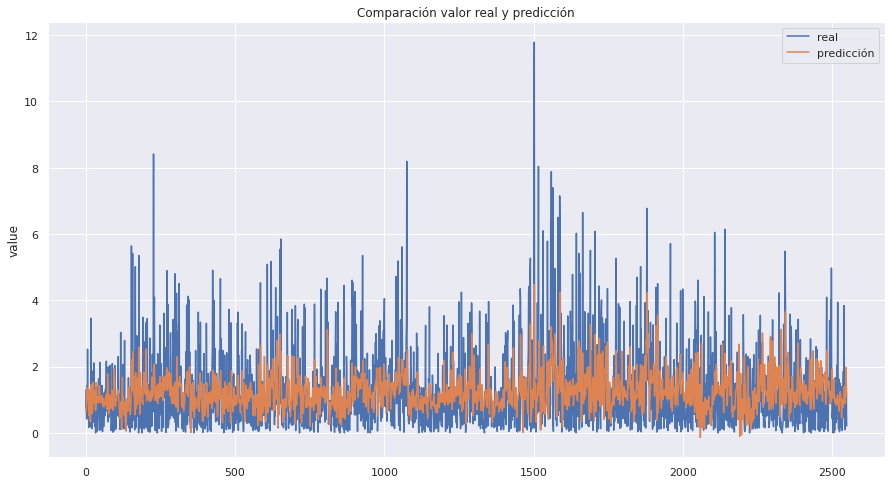

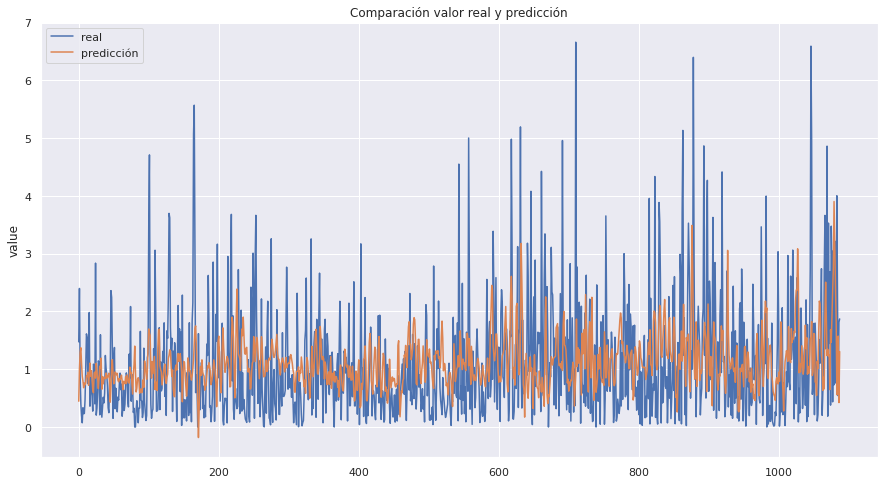

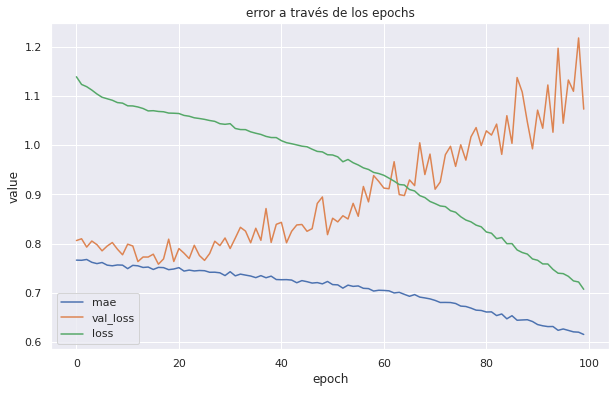

34/34 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 0.9911098667290571
MAE is : 0.72365457061792
RMSE is : 0.9955450098961157
MAPE is : 36.05736462109005
Evaluation metric results:
MSE is : 1.1214615375163572
MAE is : 0.7997778297975043
RMSE is : 1.0589908108743706
MAPE is : 42.02446244011902
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 5s 21ms/step - loss: 1.1289 - mae: 0.7606 - val_loss: 0.7906 - val_mae: 0.6974
Epoch 2/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1126 - mae: 0.7616 - val_loss: 0.7883 - val_mae: 0.6961
Epoch 3/100
128/128 [==============================] - 2s 19ms/step - loss: 1.1073 - mae: 0.7632 - val_loss: 0.7732 - val_mae: 0.6891
Epoch 4/100
128/128 [==============================] - 2s 19ms/step - loss: 1.0999 - mae: 0.7577 - val_loss: 0.7846 - val_mae: 0.7031
Epoch 5/100
128/128 [==============================] - 2s 19ms/step - loss: 1.0916 - ma

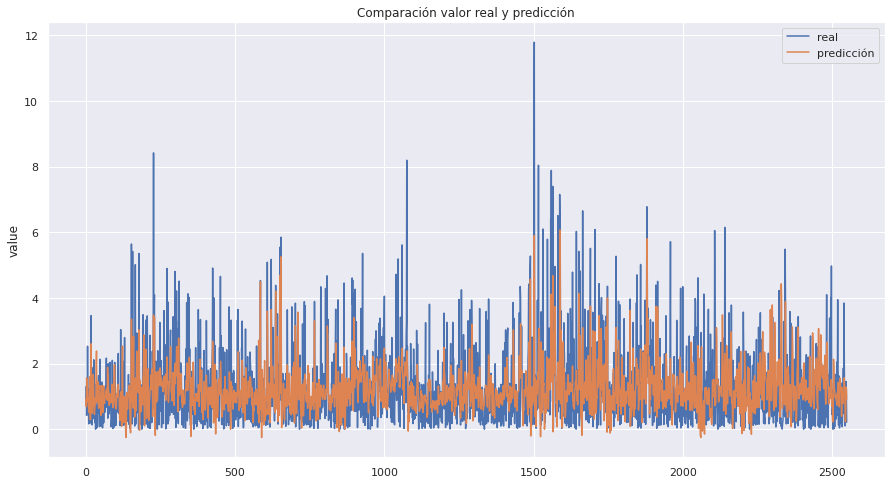

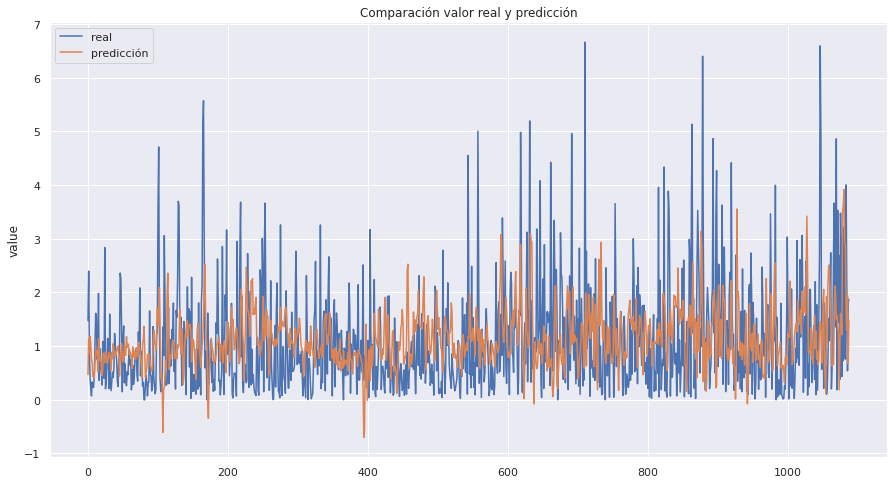

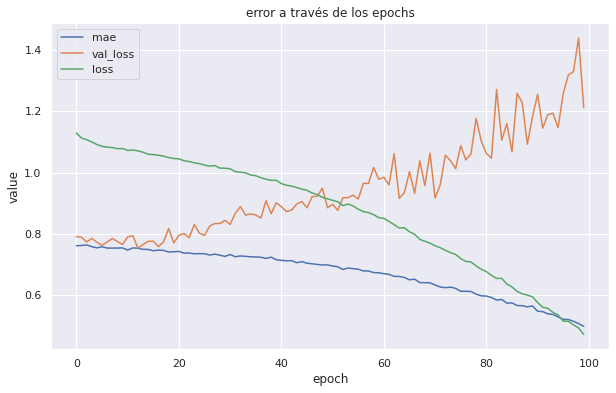

34/34 [==============================] - 0s 11ms/step
Evaluation metric results:
MSE is : 0.773366744951223
MAE is : 0.6243403733559382
RMSE is : 0.8794127273079592
MAPE is : 31.662568941317414
Evaluation metric results:
MSE is : 1.3682434495509832
MAE is : 0.8659423132052585
RMSE is : 1.1697193892344364
MAPE is : 45.5959052360682
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 11s 60ms/step - loss: 1.1375 - mae: 0.7651 - val_loss: 0.7884 - val_mae: 0.6995
Epoch 2/100
128/128 [==============================] - 7s 52ms/step - loss: 1.1105 - mae: 0.7614 - val_loss: 0.7787 - val_mae: 0.6853
Epoch 3/100
128/128 [==============================] - 7s 55ms/step - loss: 1.1039 - mae: 0.7617 - val_loss: 0.7655 - val_mae: 0.6878
Epoch 4/100
128/128 [==============================] - 7s 55ms/step - loss: 1.0962 - mae: 0.7562 - val_loss: 0.7768 - val_mae: 0.6988
Epoch 5/100
128/128 [==============================] - 7s 52ms/step - loss: 1.0880 -

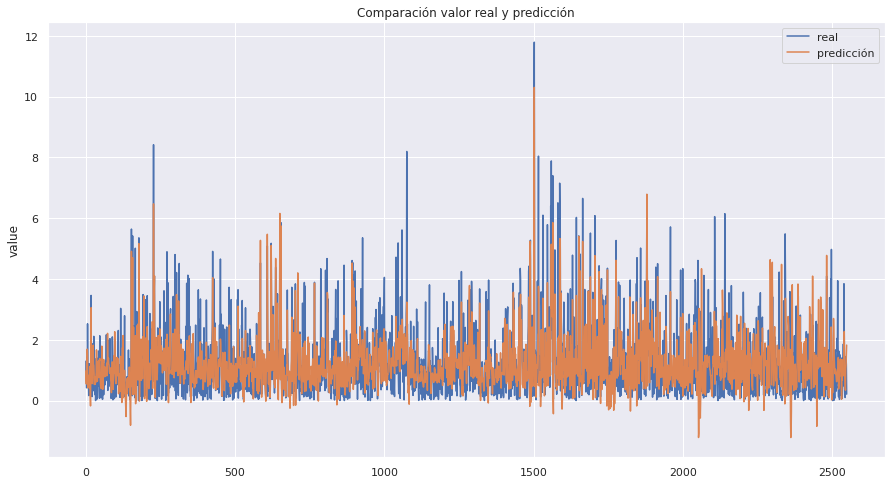

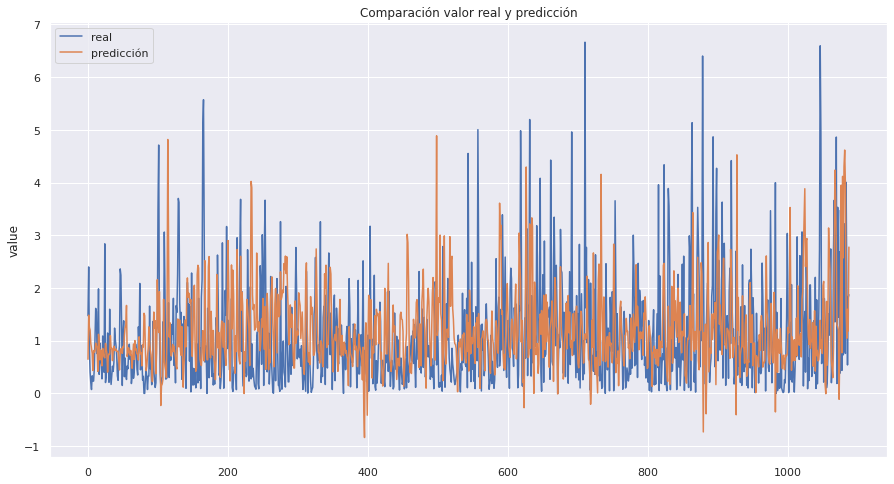

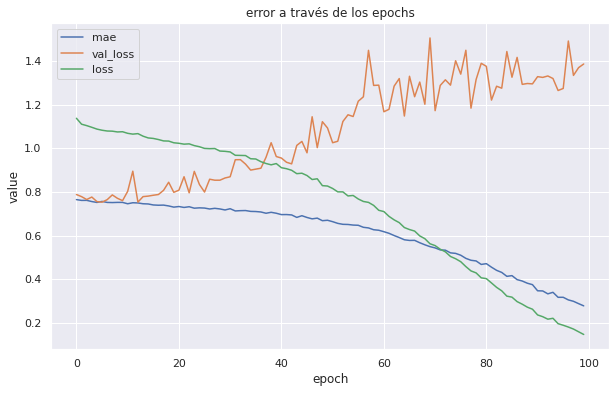

34/34 [==============================] - 1s 18ms/step
Evaluation metric results:
MSE is : 0.5110403990197053
MAE is : 0.4559521109512615
RMSE is : 0.7148708967496896
MAPE is : 23.814671262989336
Evaluation metric results:
MSE is : 1.6059646936131002
MAE is : 0.9339874074112432
RMSE is : 1.2672666229381646
MAPE is : 48.36465093644837
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 16ms/step - loss: 1.1970 - mae: 0.7902 - val_loss: 0.7904 - val_mae: 0.6941
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1397 - mae: 0.7710 - val_loss: 0.8013 - val_mae: 0.7098
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1297 - mae: 0.7688 - val_loss: 0.8028 - val_mae: 0.7119
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1242 - mae: 0.7698 - val_loss: 0.8033 - val_mae: 0.7131
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.120

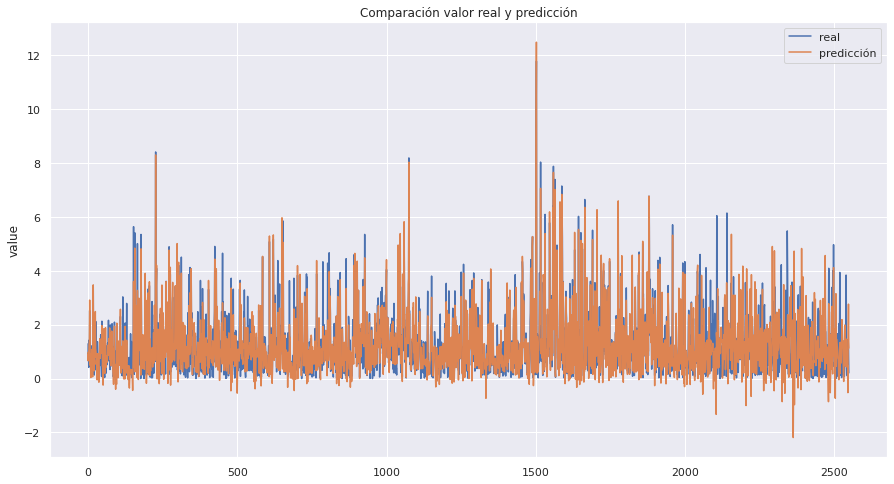

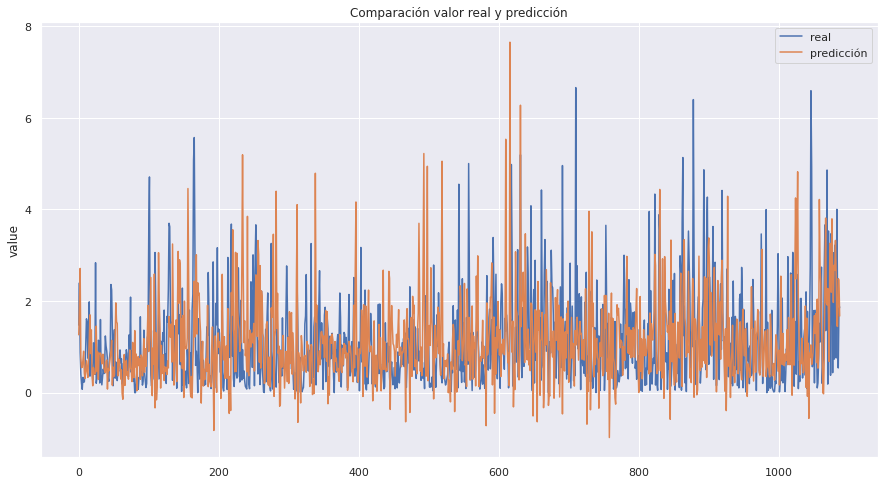

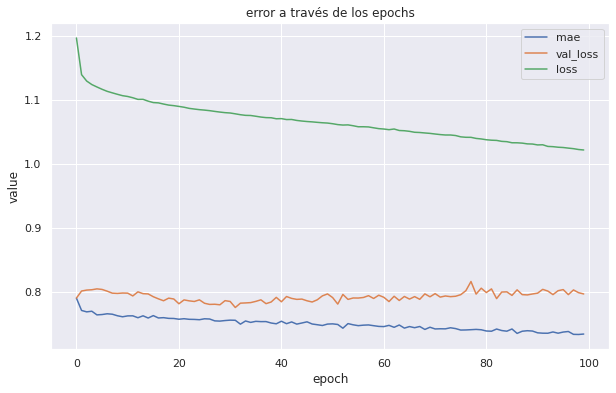

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.2629019083567639
MAE is : 0.8291253568940221
RMSE is : 1.1237890853522132
MAPE is : 41.43918551534378
Evaluation metric results:
MSE is : 0.9687882271992139
MAE is : 0.7458309577906708
RMSE is : 0.9842704034965258
MAPE is : 40.00961918648437
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 16ms/step - loss: 1.1743 - mae: 0.7767 - val_loss: 0.8113 - val_mae: 0.7078
Epoch 2/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1333 - mae: 0.7713 - val_loss: 0.8163 - val_mae: 0.7140
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1246 - mae: 0.7702 - val_loss: 0.8134 - val_mae: 0.7109
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1195 - mae: 0.7723 - val_loss: 0.8148 - val_mae: 0.7132
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1159 - m

Epoch 59/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0416 - mae: 0.7391 - val_loss: 0.8208 - val_mae: 0.7285
Epoch 60/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0394 - mae: 0.7384 - val_loss: 0.8290 - val_mae: 0.7339
Epoch 61/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0376 - mae: 0.7369 - val_loss: 0.8179 - val_mae: 0.7264
Epoch 62/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0367 - mae: 0.7398 - val_loss: 0.8091 - val_mae: 0.7181
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0372 - mae: 0.7351 - val_loss: 0.8259 - val_mae: 0.7322
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0315 - mae: 0.7378 - val_loss: 0.8224 - val_mae: 0.7268
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0325 - mae: 0.7333 - val_loss: 0.8204 - val_mae: 0.7282
Epoch 66/100
128/128 [==============================] - 1s 8ms

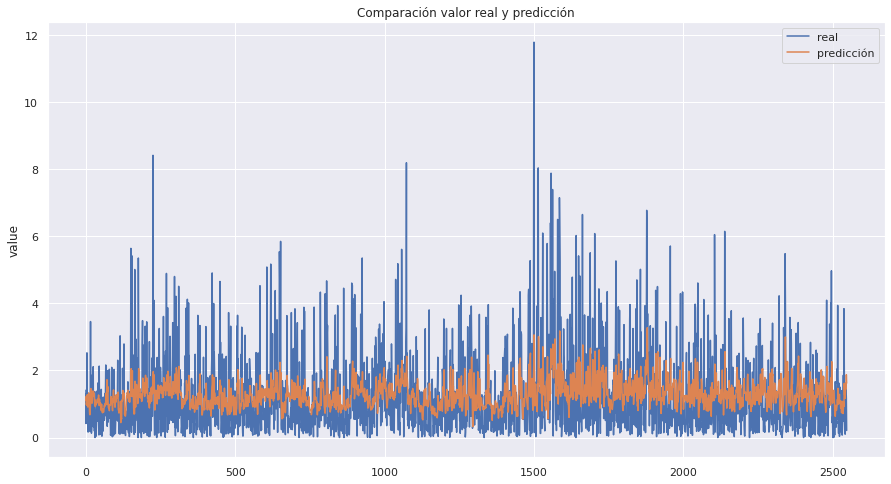

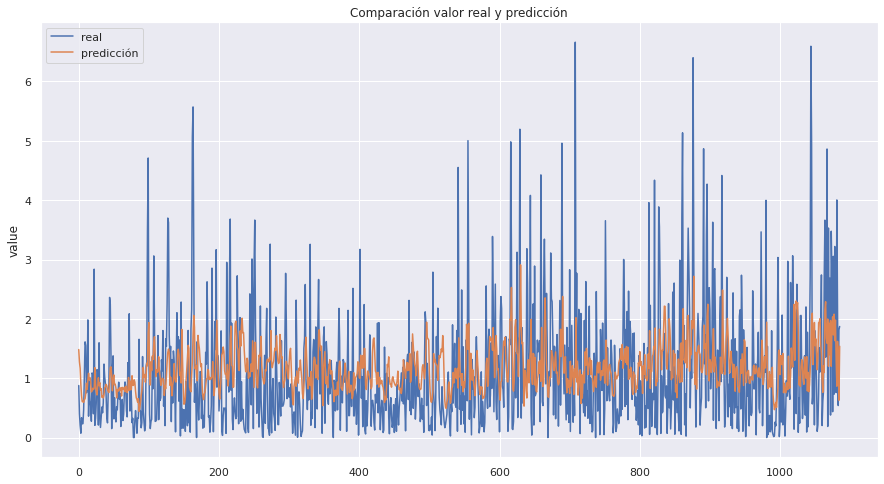

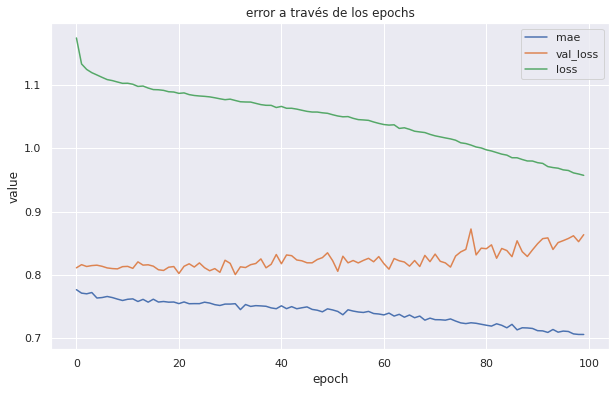

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.208640781318714
MAE is : 0.8051742900503832
RMSE is : 1.0993819997247154
MAPE is : 40.14460225845896
Evaluation metric results:
MSE is : 1.0107192640038825
MAE is : 0.7660246246103607
RMSE is : 1.0053453456419255
MAPE is : 41.18076389587988
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 16ms/step - loss: 1.1324 - mae: 0.7645 - val_loss: 0.8057 - val_mae: 0.7019
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1193 - mae: 0.7669 - val_loss: 0.8042 - val_mae: 0.7029
Epoch 3/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1147 - mae: 0.7650 - val_loss: 0.7975 - val_mae: 0.6968
Epoch 4/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1109 - mae: 0.7677 - val_loss: 0.7997 - val_mae: 0.7021
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1071 -

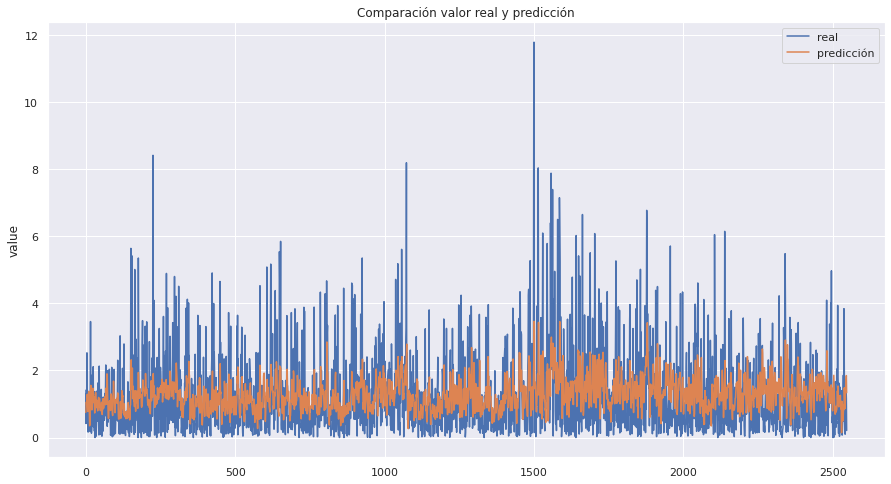

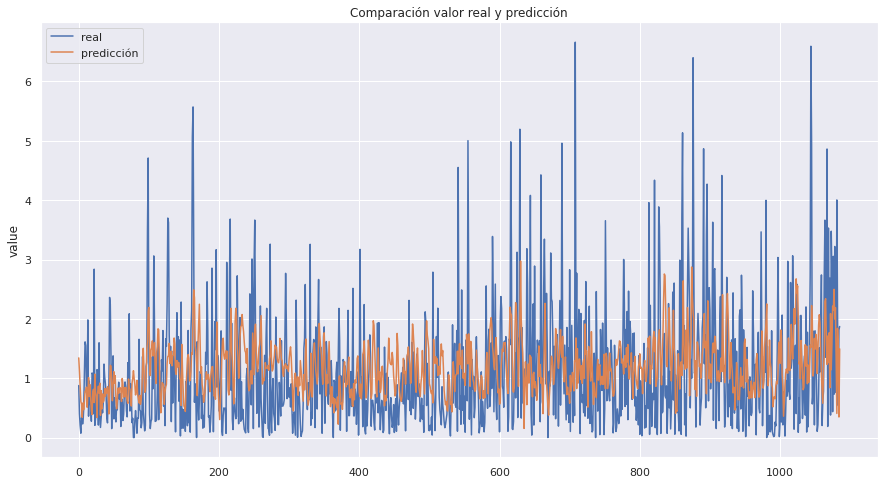

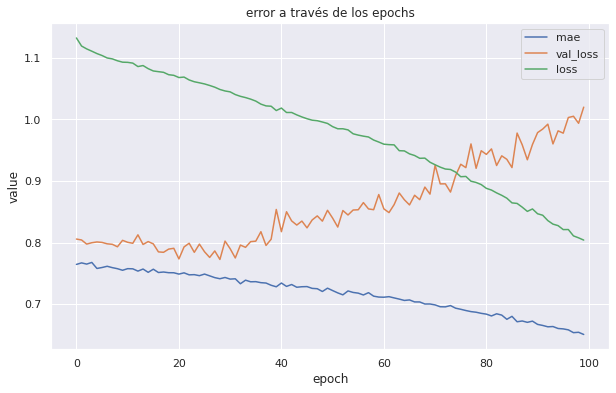

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.0750892484053183
MAE is : 0.7635013264217545
RMSE is : 1.0368651061759762
MAPE is : 38.45831072123672
Evaluation metric results:
MSE is : 1.14839915444666
MAE is : 0.8093409252780115
RMSE is : 1.0716338714536136
MAPE is : 42.651517564453506
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 6s 18ms/step - loss: 1.1405 - mae: 0.7697 - val_loss: 0.8044 - val_mae: 0.7016
Epoch 2/100
128/128 [==============================] - 2s 15ms/step - loss: 1.1216 - mae: 0.7682 - val_loss: 0.8015 - val_mae: 0.7048
Epoch 3/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1152 - mae: 0.7651 - val_loss: 0.7938 - val_mae: 0.6943
Epoch 4/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1109 - mae: 0.7674 - val_loss: 0.7930 - val_mae: 0.6992
Epoch 5/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1050 -

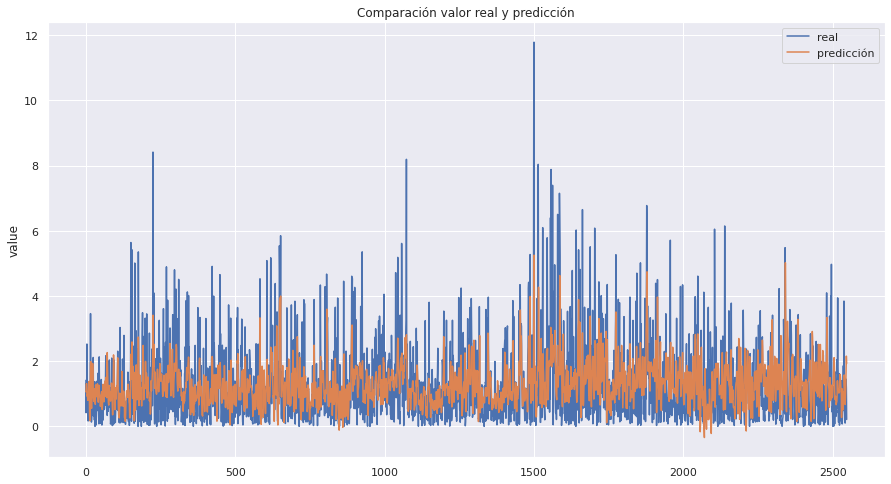

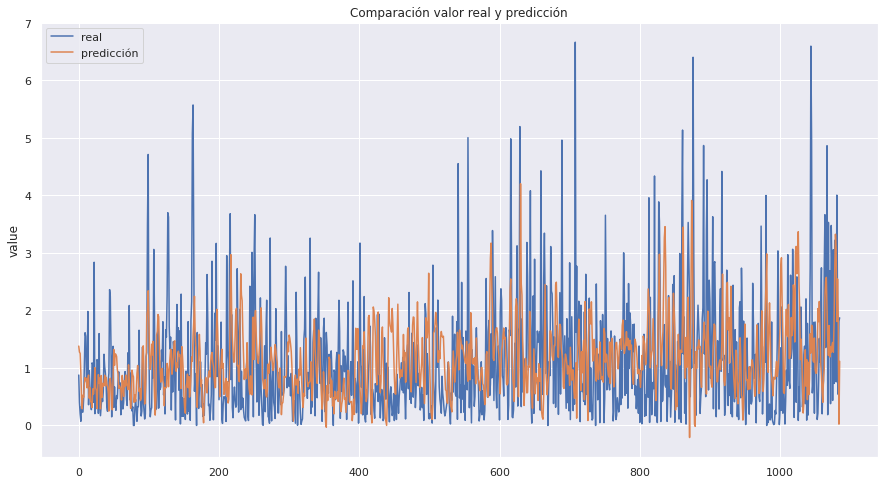

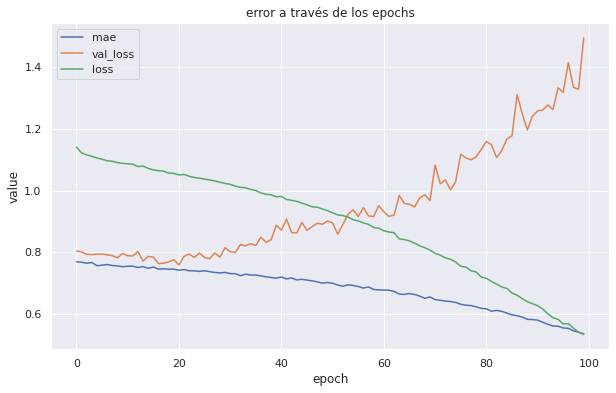

34/34 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 0.9026195087010448
MAE is : 0.6895979287952843
RMSE is : 0.9500628972342015
MAPE is : 36.25988858950493
Evaluation metric results:
MSE is : 1.2912296256124822
MAE is : 0.8569913135040167
RMSE is : 1.136322852719456
MAPE is : 47.155189716291716
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 7s 29ms/step - loss: 1.1460 - mae: 0.7716 - val_loss: 0.8035 - val_mae: 0.6982
Epoch 2/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1227 - mae: 0.7682 - val_loss: 0.7975 - val_mae: 0.7045
Epoch 3/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1146 - mae: 0.7639 - val_loss: 0.7833 - val_mae: 0.6849
Epoch 4/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1076 - mae: 0.7651 - val_loss: 0.7774 - val_mae: 0.6885
Epoch 5/100
128/128 [==============================] - 3s 23ms/step - loss: 1.0992 

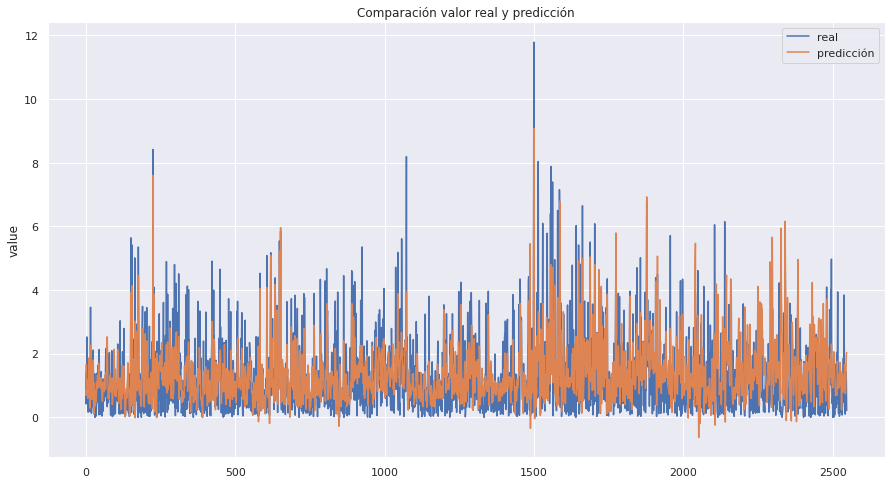

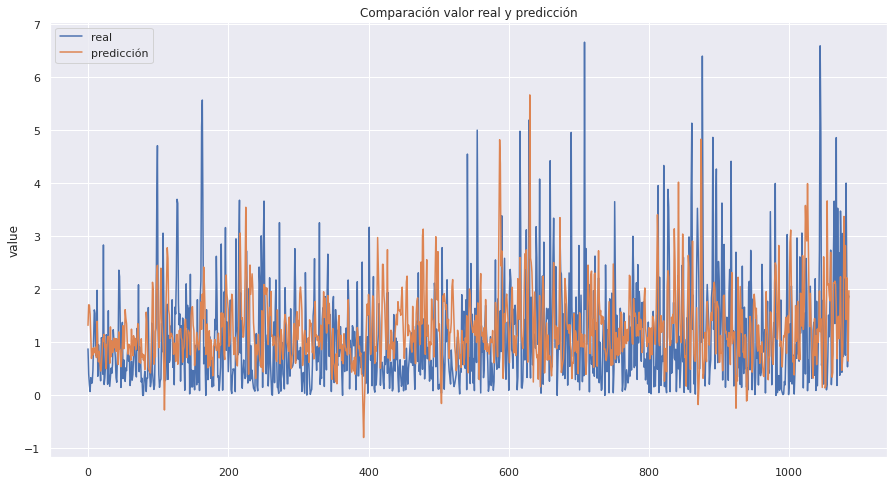

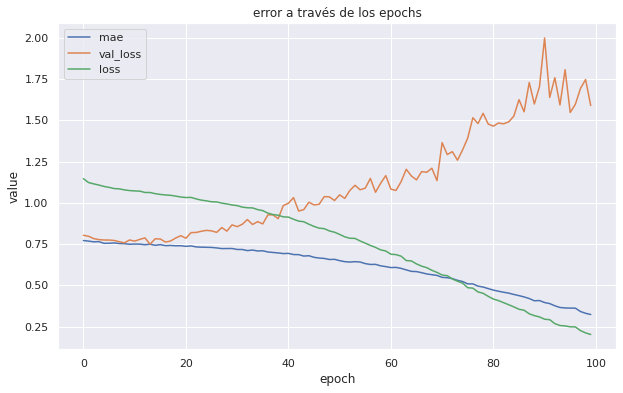

34/34 [==============================] - 0s 12ms/step
Evaluation metric results:
MSE is : 0.5933638765342374
MAE is : 0.4803974550008138
RMSE is : 0.7703011596344883
MAPE is : 25.06526628946394
Evaluation metric results:
MSE is : 1.5471342729092388
MAE is : 0.9312225308836175
RMSE is : 1.243838523647358
MAPE is : 50.23774038219081
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 8s 41ms/step - loss: 1.1520 - mae: 0.7729 - val_loss: 0.7967 - val_mae: 0.6950
Epoch 2/100
128/128 [==============================] - 5s 37ms/step - loss: 1.1168 - mae: 0.7660 - val_loss: 0.7871 - val_mae: 0.7002
Epoch 3/100
128/128 [==============================] - 5s 38ms/step - loss: 1.1080 - mae: 0.7624 - val_loss: 0.7664 - val_mae: 0.6763
Epoch 4/100
128/128 [==============================] - 5s 39ms/step - loss: 1.0994 - mae: 0.7618 - val_loss: 0.7584 - val_mae: 0.6780
Epoch 5/100
128/128 [==============================] - 5s 38ms/step - loss: 1.0916 

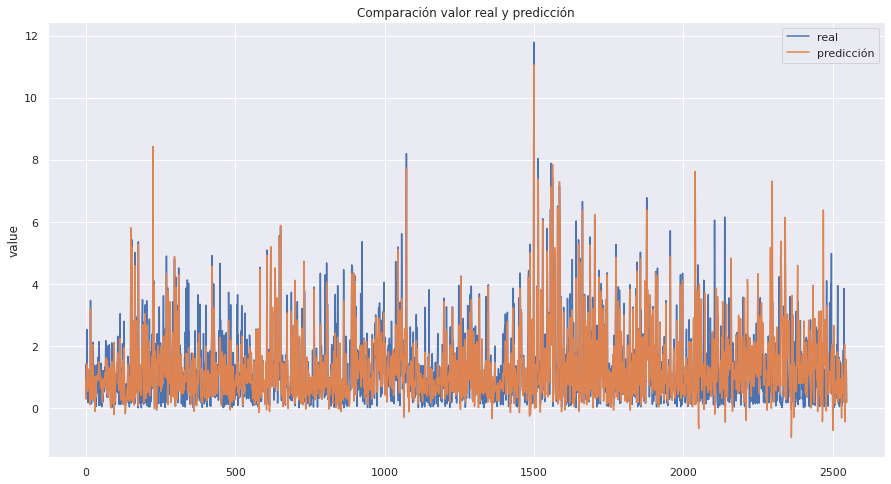

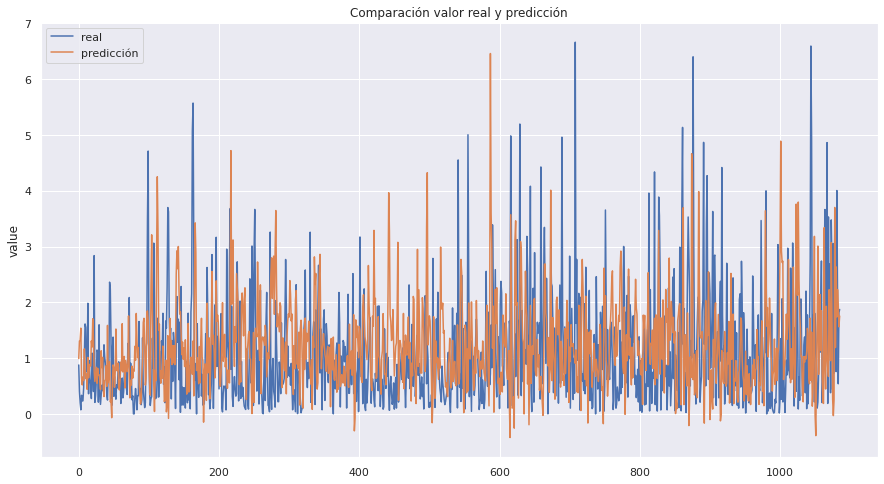

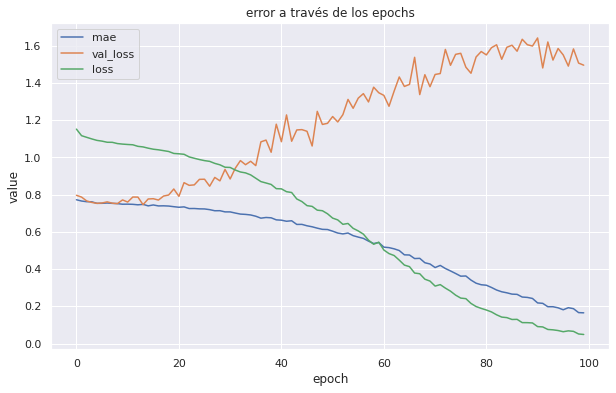

34/34 [==============================] - 1s 21ms/step
Evaluation metric results:
MSE is : 0.4350063162856079
MAE is : 0.35465431803585573
RMSE is : 0.6595500862600261
MAPE is : 18.609263514754886
Evaluation metric results:
MSE is : 1.6345185872165224
MAE is : 0.9446043148498442
RMSE is : 1.2784829241004834
MAPE is : 51.03686228064392
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 5s 18ms/step - loss: 1.2061 - mae: 0.7893 - val_loss: 0.7919 - val_mae: 0.6851
Epoch 2/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1477 - mae: 0.7694 - val_loss: 0.8013 - val_mae: 0.7027
Epoch 3/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1336 - mae: 0.7658 - val_loss: 0.8108 - val_mae: 0.7138
Epoch 4/100
128/128 [==============================] - 2s 14ms/step - loss: 1.1253 - mae: 0.7687 - val_loss: 0.8146 - val_mae: 0.7178
Epoch 5/100
128/128 [==============================] - 2s 13ms/step - loss: 1.11

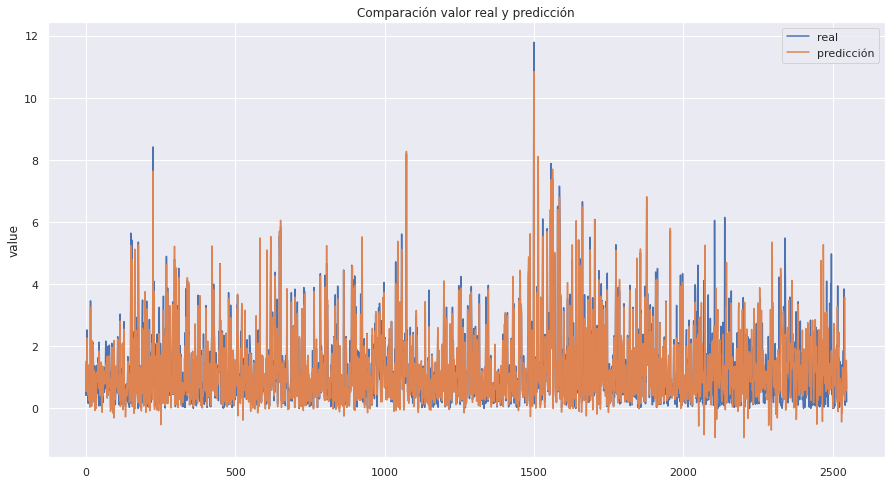

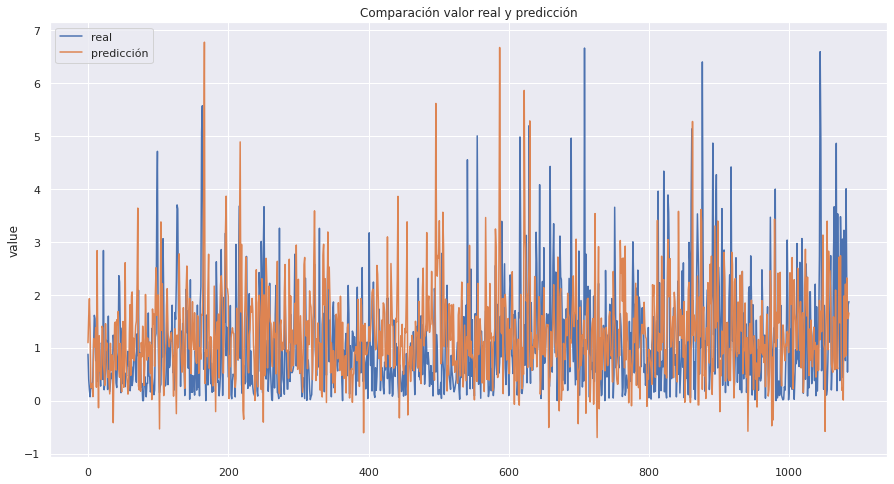

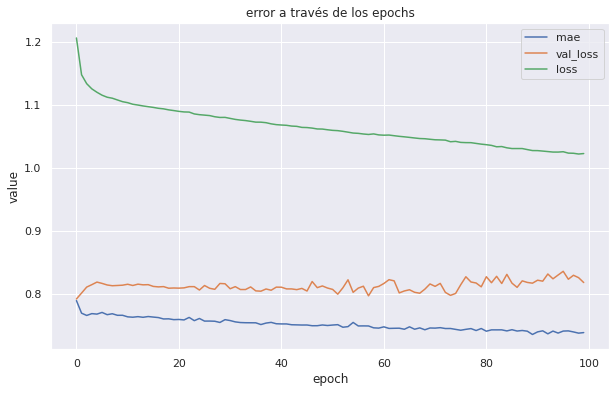

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2682507446925113
MAE is : 0.8293745647227682
RMSE is : 1.1261663929866277
MAPE is : 40.94273838382342
Evaluation metric results:
MSE is : 0.9792891674852783
MAE is : 0.7510890999184472
RMSE is : 0.9895904038971267
MAPE is : 40.13126927848501
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 6s 22ms/step - loss: 1.1526 - mae: 0.7662 - val_loss: 0.8093 - val_mae: 0.7048
Epoch 2/100
128/128 [==============================] - 2s 18ms/step - loss: 1.1238 - mae: 0.7683 - val_loss: 0.8115 - val_mae: 0.7089
Epoch 3/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1170 - mae: 0.7615 - val_loss: 0.8146 - val_mae: 0.7116
Epoch 4/100
128/128 [==============================] - 2s 18ms/step - loss: 1.1126 - mae: 0.7669 - val_loss: 0.8132 - val_mae: 0.7109
Epoch 5/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1103 

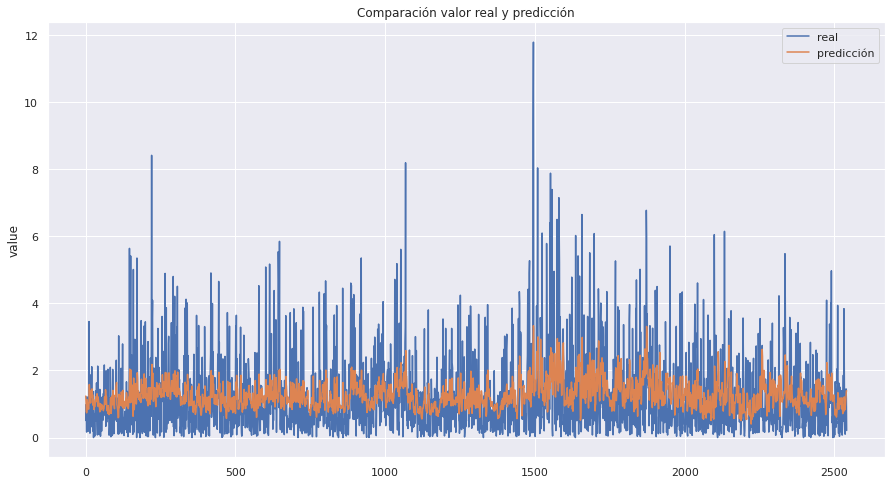

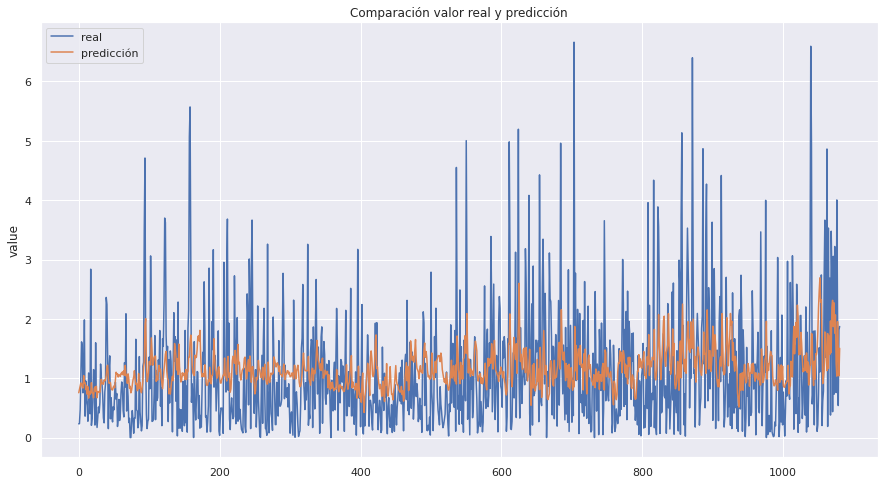

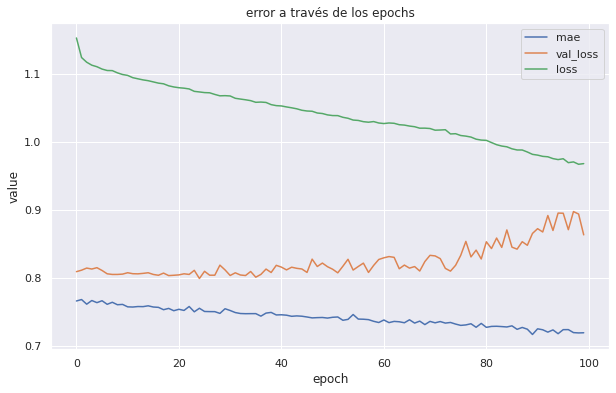

34/34 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.2196097000316035
MAE is : 0.8111610583463185
RMSE is : 1.1043594070915517
MAPE is : 39.94036574780158
Evaluation metric results:
MSE is : 1.022489643393061
MAE is : 0.771436462604684
RMSE is : 1.0111822997823197
MAPE is : 40.79262426795637
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 6s 21ms/step - loss: 1.1355 - mae: 0.7644 - val_loss: 0.8183 - val_mae: 0.7168
Epoch 2/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1178 - mae: 0.7702 - val_loss: 0.8098 - val_mae: 0.7103
Epoch 3/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1113 - mae: 0.7594 - val_loss: 0.8158 - val_mae: 0.7167
Epoch 4/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1076 - mae: 0.7675 - val_loss: 0.8145 - val_mae: 0.7161
Epoch 5/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1036 - 

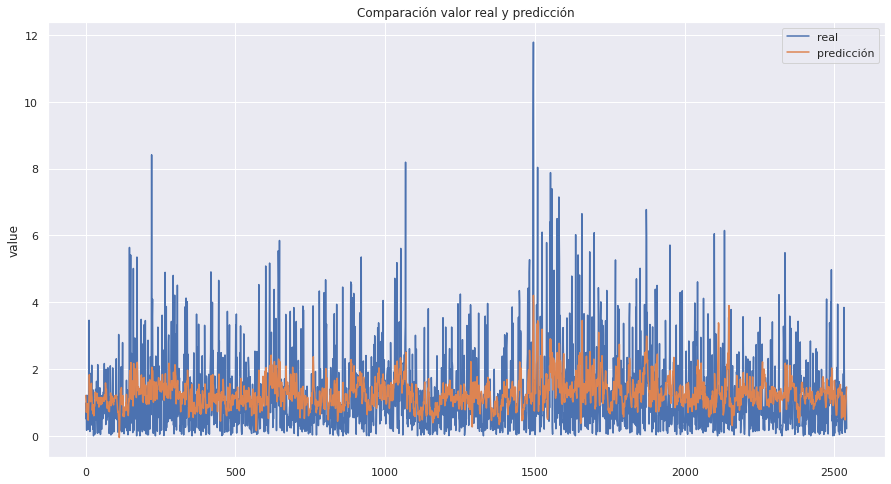

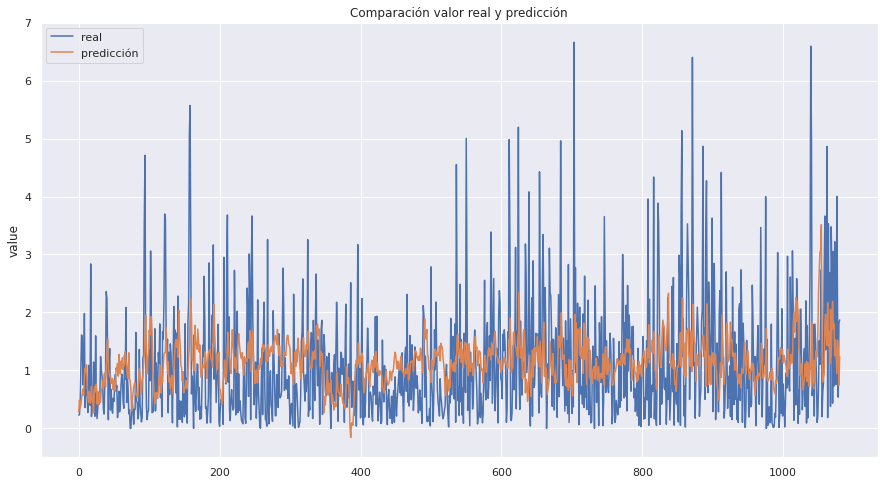

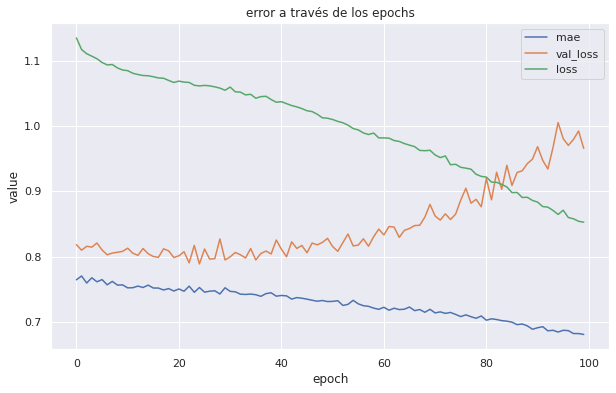

34/34 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 1.1174408469635333
MAE is : 0.7799876845111344
RMSE is : 1.0570907467968553
MAPE is : 38.61539279023208
Evaluation metric results:
MSE is : 1.1278857564987217
MAE is : 0.7990632458257656
RMSE is : 1.0620196591865527
MAPE is : 42.10877335308269
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 9s 31ms/step - loss: 1.1444 - mae: 0.7676 - val_loss: 0.8267 - val_mae: 0.7235
Epoch 2/100
128/128 [==============================] - 3s 22ms/step - loss: 1.1179 - mae: 0.7723 - val_loss: 0.7969 - val_mae: 0.7002
Epoch 3/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1065 - mae: 0.7560 - val_loss: 0.8172 - val_mae: 0.7155
Epoch 4/100
128/128 [==============================] - 3s 23ms/step - loss: 1.1031 - mae: 0.7667 - val_loss: 0.8085 - val_mae: 0.7120
Epoch 5/100
128/128 [==============================] - 3s 24ms/step - loss: 1.0974 

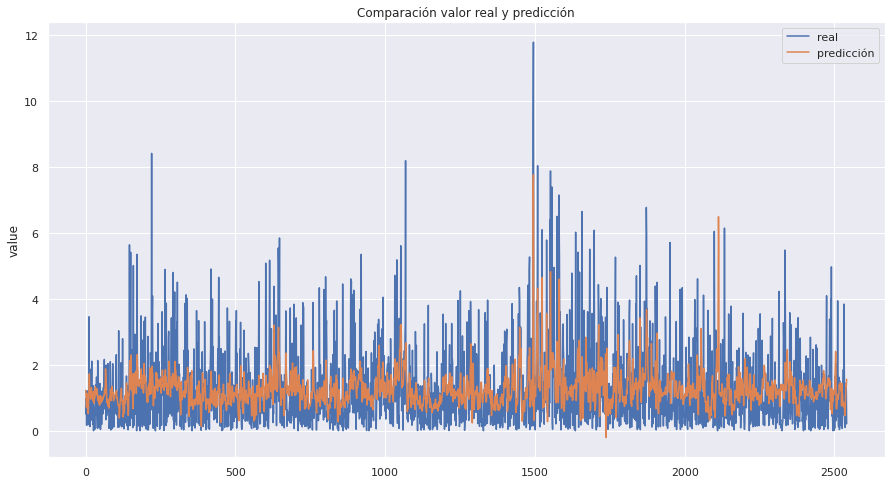

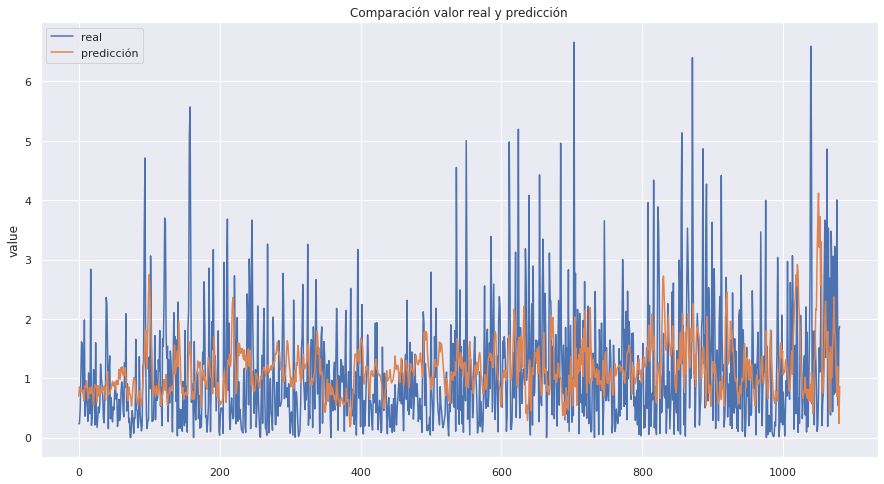

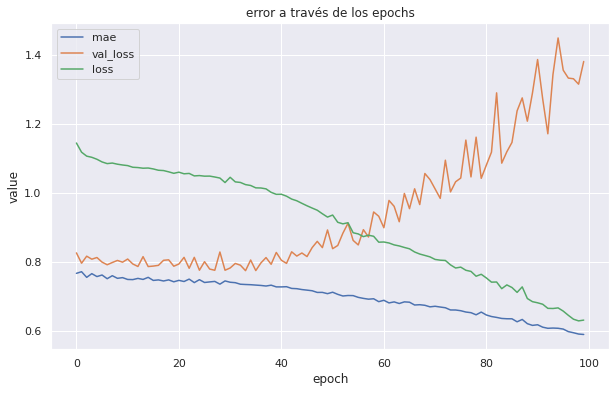

34/34 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 0.9715479802589789
MAE is : 0.7176137271269953
RMSE is : 0.9856713348063739
MAPE is : 36.992411140058
Evaluation metric results:
MSE is : 1.4826434512100828
MAE is : 0.8896082552678118
RMSE is : 1.2176384731151044
MAPE is : 47.17075681904809
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 7s 34ms/step - loss: 1.1504 - mae: 0.7697 - val_loss: 0.8279 - val_mae: 0.7225
Epoch 2/100
128/128 [==============================] - 3s 25ms/step - loss: 1.1161 - mae: 0.7691 - val_loss: 0.7845 - val_mae: 0.6898
Epoch 3/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1015 - mae: 0.7531 - val_loss: 0.8167 - val_mae: 0.7089
Epoch 4/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1001 - mae: 0.7638 - val_loss: 0.7951 - val_mae: 0.7018
Epoch 5/100
128/128 [==============================] - 3s 25ms/step - loss: 1.0970 - 

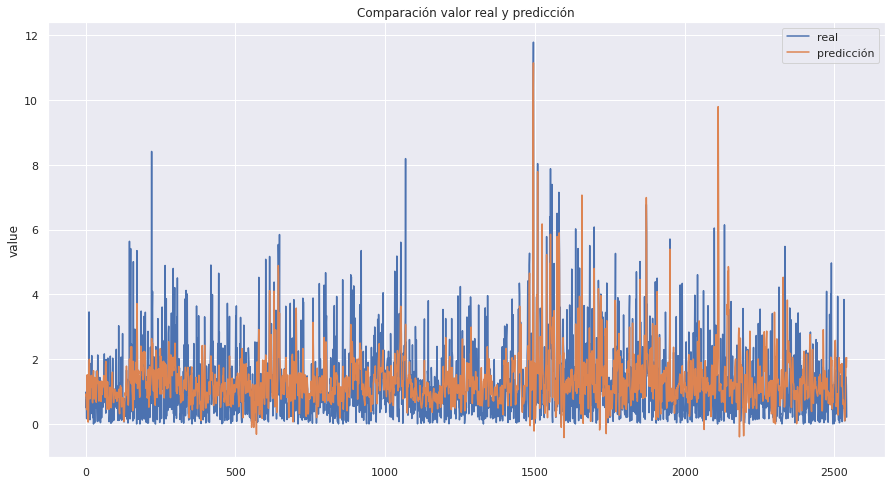

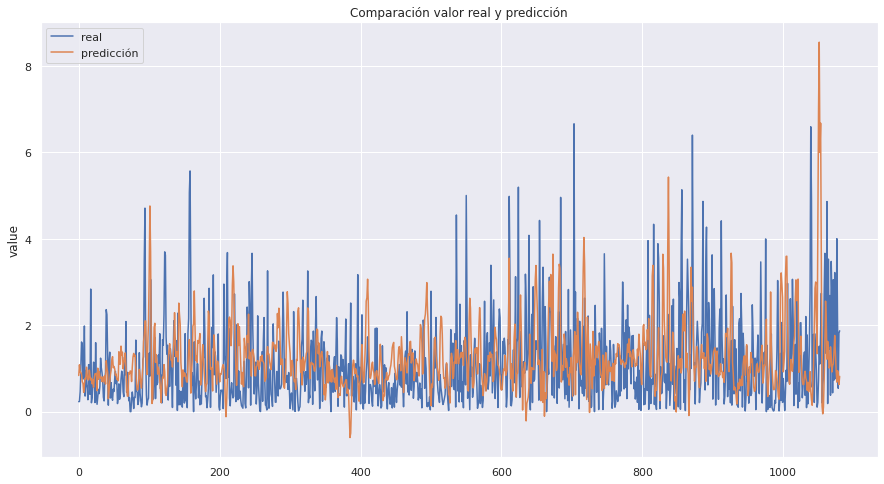

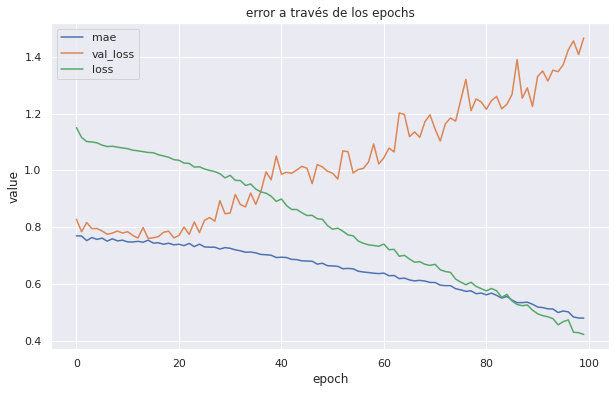

34/34 [==============================] - 1s 15ms/step
Evaluation metric results:
MSE is : 0.7859407432713384
MAE is : 0.6171835941813448
RMSE is : 0.8865329905149263
MAPE is : 31.38005210034664
Evaluation metric results:
MSE is : 1.5586791935114201
MAE is : 0.8885054046590656
RMSE is : 1.2484707419524976
MAPE is : 45.02479530251351
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 16s 85ms/step - loss: 1.1387 - mae: 0.7643 - val_loss: 0.8110 - val_mae: 0.7129
Epoch 2/100
128/128 [==============================] - 10s 79ms/step - loss: 1.1122 - mae: 0.7661 - val_loss: 0.7717 - val_mae: 0.6834
Epoch 3/100
128/128 [==============================] - 10s 79ms/step - loss: 1.0948 - mae: 0.7517 - val_loss: 0.7987 - val_mae: 0.6969
Epoch 4/100
128/128 [==============================] - 10s 80ms/step - loss: 1.0939 - mae: 0.7608 - val_loss: 0.7781 - val_mae: 0.6919
Epoch 5/100
128/128 [==============================] - 10s 79ms/step - loss: 1

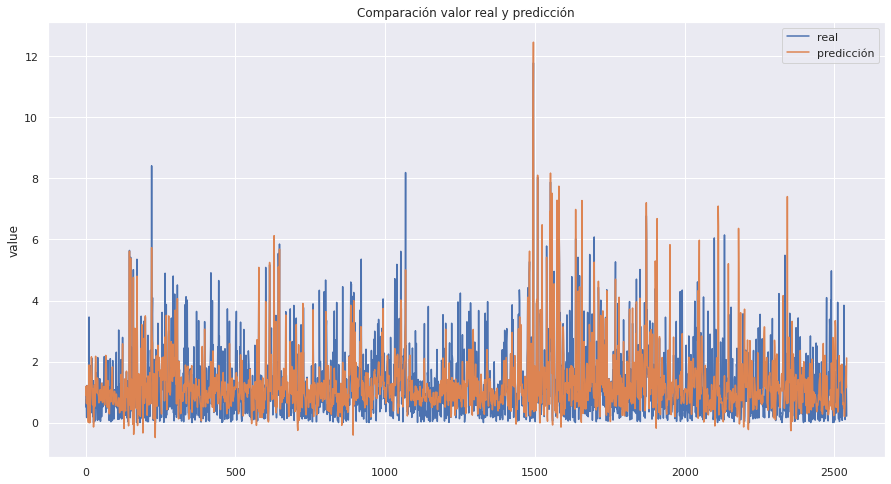

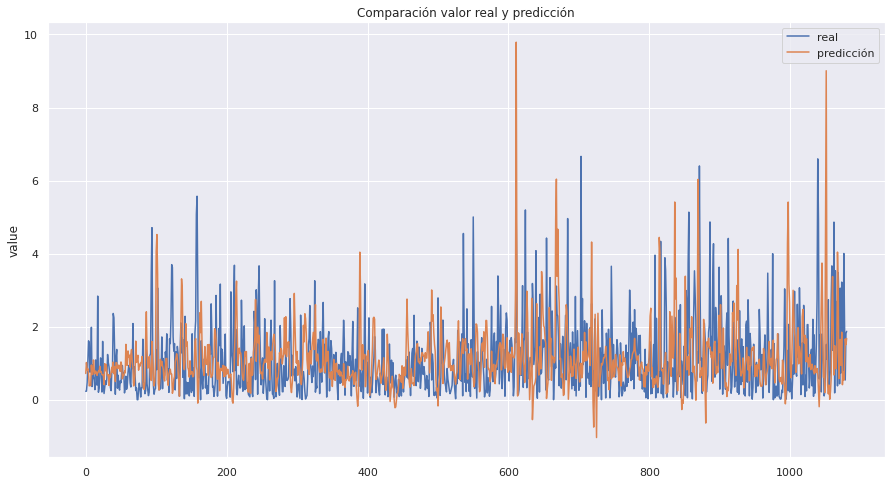

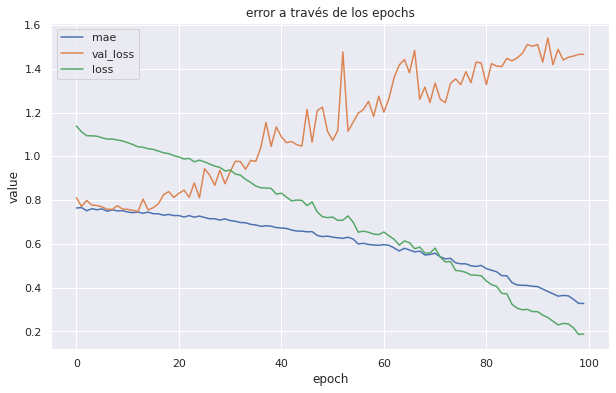

34/34 [==============================] - 1s 31ms/step
Evaluation metric results:
MSE is : 0.5605362757415837
MAE is : 0.49614942115114863
RMSE is : 0.7486897059139946
MAPE is : 25.949050917648663
Evaluation metric results:
MSE is : 1.7109742933071956
MAE is : 0.9468596946226341
RMSE is : 1.30804216037068
MAPE is : 49.07441274404375


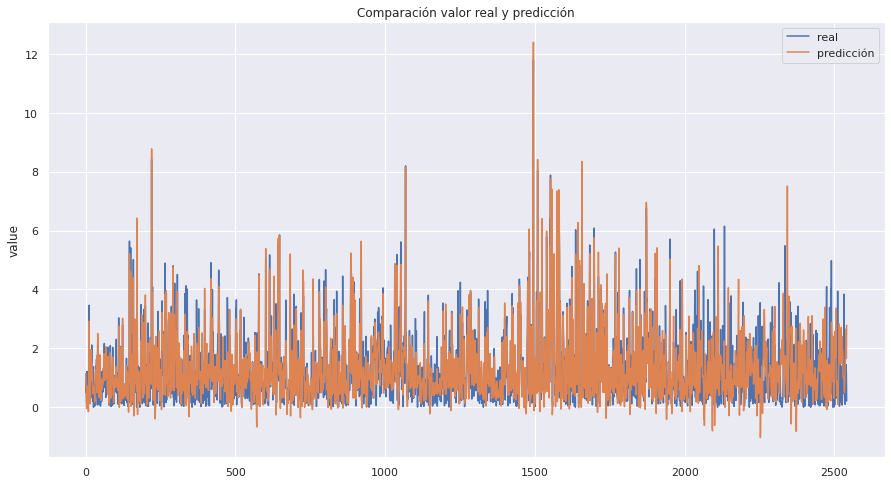

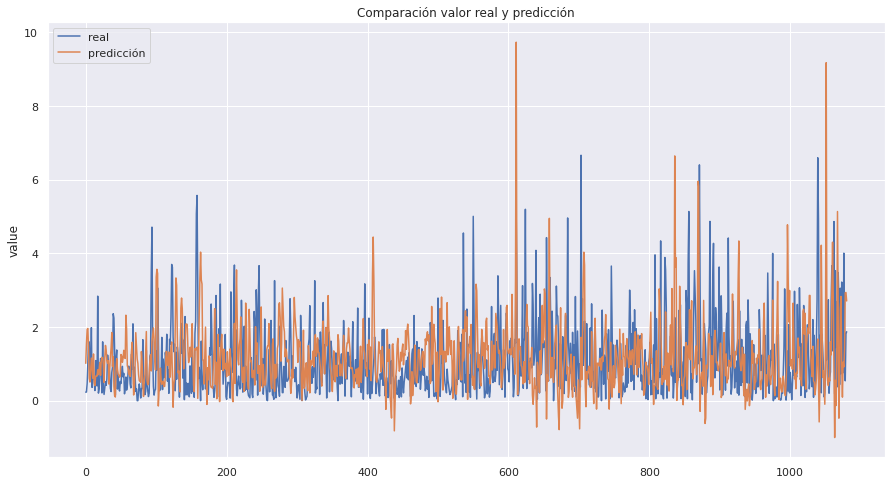

In [12]:
lags=[5,8,10,15]
neuronss=[16,32,64,128,256,512]
results_models={i:{} for i in lags}
for lg in lags:
    for neuron in neuronss:
        results_models[lg][neuron]=Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=4,epochss=100,batch_sizze=16,lag=lg)